In [1]:
# Common Libraries
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os, sys
import json
import torch
import argparse
import gc
import time
import glob
import random
import ssl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, Column

# Detectron setup
import detectron2.utils.comm as comm
from detectron2.utils.logger import setup_logger
setup_logger() # Setup detectron2 logger
from detectron2.config import LazyConfig, get_cfg
from detectron2.engine import launch
# for evaluating model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import deepdisc.astrodet.astrodet as toolkit
import detectron2.data as d2data
# for getting precision and recall
from detectron2 import structures
from detectron2.structures import BoxMode

# deepdisc imports
from deepdisc.data_format.image_readers import RomanImageReader
from deepdisc.data_format.register_data import register_data_set
from deepdisc.inference.predictors import return_predictor_transformer, get_predictions

# Utils to analyze model
from plot_eval_utils import plot_losses, plot_det_gt, evaluate_model, plot_ap, get_pr

/home/yse2/.conda/envs/deepdisc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# for base LSST run - no combined
# run_dir = './lsst_runs/run2_sm'
# output_dir = './lsst_runs/run2_sm'
# test_data_fi = './lsst_data/annotations/test.json'
# cfgfile = "./deepdisc/configs/solo/swin_lsst.py"

# for combined run - but just padding no upsampling
# run_dir = './lsst_runs/run3_pad_roman'
# output_dir = './lsst_runs/run3_pad_roman'
# test_data_fi = './lsst_data/annotationsc-pad/test.json'
# cfgfile = "./deepdisc/configs/solo/swin_lsst_pad.py"

run_dir = './lsst_runs/run4_ups_roman'
output_dir = './lsst_runs/run4_ups_roman'
test_data_fi = './lsst_data/annotationsc-ups/test.json'
cfgfile = "./deepdisc/configs/solo/swinc_lsst_ups.py"

# all the below cells use this below threshold
topk_per_img = 2000
score_thresh = 0.3
nms_thresh = 0.4
imreader = RomanImageReader()

In [3]:
def img_key_mapper(dataset_dict):
    fn = dataset_dict["file_name"]
    return fn

def load_model_config(run_dir, cfgfile, topk_per_img, score_thresh, nms_thresh, test_data_fi):
    
    pth_files = glob.glob(os.path.join(run_dir, '*.pth'))
    if pth_files:
        for pth in pth_files:
            if "instances" in pth: # ignore any instances.pth from evaluation 
                continue
            else:
                model_path = pth
        print(f"Using checkpoint file found in {run_dir}: {model_path}")
    else:
        model_path = input(f"No .pth file found in {run_dir}. Provide the path to the model checkpoint file: ")
        return
    
    print(f"\nLoading configs from {cfgfile}...")
    cfg = LazyConfig.load(cfgfile)
    for key in cfg.get("MISC", dict()).keys():
        cfg[key] = cfg.MISC[key]
    
    ## Preparing for inference on random image from test data
    print(f"\nLoading model from {model_path}...")
    cfg.train.init_checkpoint = model_path # path to trained model
    for box_predictor in cfg.model.roi_heads.box_predictors:
        box_predictor.test_topk_per_image = topk_per_img
        box_predictor.test_score_thresh = score_thresh
        box_predictor.test_nms_thresh = nms_thresh

    # get predictor model
    predictor = return_predictor_transformer(cfg)
    
    # loading in test metadata
    print(f"\nLoading in test data from {test_data_fi}...")
    with open(test_data_fi, 'r') as f:
        data = json.load(f)
    # registering the test metadata
    try:
        custom_colors = [
            (0, 255, 0),    # Green
            (0, 0, 255),    # Blue
        ]
        test_set = register_data_set('test', test_data_fi, thing_classes=["galaxy", "star"]).set(thing_colors=custom_colors)
    except AssertionError:
        print("\nroman_test already registered!")  
        # return cfg, predictor, img_key_mapper
    
    return cfg, predictor, img_key_mapper, data

In [48]:
cfg, predictor, img_key_mapper, test_data = load_model_config(run_dir, cfgfile, topk_per_img, score_thresh, nms_thresh, test_data_fi)

Using checkpoint file found in ./lsst_runs/run2_sm: ./lsst_runs/run2_sm/lsst.pth

Loading configs from ./deepdisc/configs/solo/swin_lsst.py...

Loading model from ./lsst_runs/run2_sm/lsst.pth...
[11/01 10:06:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./lsst_runs/run2_sm/lsst.pth ...

Loading in test data from ./lsst_data/annotations/test.json...

roman_test already registered!


In [5]:
def evaluate_model(cfg, predictor, output_dir, img_key_mapper):
    mapper = cfg.dataloader.train.mapper(
        cfg.dataloader.imagereader, img_key_mapper
    ).map_data
    evaluator = toolkit.COCOEvaluatorRecall('test', use_fast_impl=True, output_dir=output_dir, allow_cached_coco=False)
    eval_loader = d2data.build_detection_test_loader(cfg, 'test', mapper=mapper)
    results = inference_on_dataset(predictor.model, eval_loader, evaluator)
    return results

In [7]:
results = evaluate_model(cfg, predictor, output_dir, img_key_mapper)

Loading  ./lsst_runs/run4_ups_roman/test_coco_format.json
[10/09 13:27:50 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   galaxy   | 18989        |    star    | 415          |
|            |              |            |              |
|   total    | 19404        |            |              |
[10/09 13:27:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/09 13:27:50 d2.data.common]: Serializing 658 elements to byte tensors and concatenating them all ...
[10/09 13:27:50 d2.data.common]: Serialized dataset takes 3.04 MiB
[10/09 13:27:50 d2.evaluation.evaluator]: Start inference on 658 batches
[10/09 13:27:54 d2.evaluation.evaluator]: Inference done 11/658. Dataloading: 0.0374 s/iter. Inference: 0.1728 s/iter. Eval: 0.0175 s/iter. Total: 0.2276 s/iter. ETA=0:02:27
[10/09 13:27:59 d2.evaluation.eva

In [10]:
total_stars = np.sum([1 if ann["category_id"] == 1 else 0 for d in test_data for ann in d["annotations"] ])
total_galaxies = np.sum([1 if ann["category_id"] == 0 else 0 for d in test_data for ann in d["annotations"]])
total_stars, total_galaxies

(415, 18989)

# Creating DeepDISC Det Cat (OLD:  Test Truth Cat)

In [11]:
# needed to handle the WCS because we have upsampled annotations that we need to scale down for the WCS since the 
# WCS hasn't been scaled for the upsampled image and exists only for the small LSST img
def get_scale_factors(orig_height, orig_width):
    scale_x = orig_width / 512 
    scale_y = orig_height / 512
    return scale_x, scale_y

def adjust_coordinates(x, y, scale_x, scale_y):
    return x * scale_x, y * scale_y  # scaling down

In [12]:
def get_truth_and_dd_det_cat(test_data, imreader, key_mapper, predictor):
    gt_ras = []
    gt_decs = []
    pred_ras = []
    pred_decs = []

    truth_info_cache = {}
    for d in test_data:
        imid = d['image_id']
        # temporary sol before I move all the corresponding correct WCS to the ups and pad dirs
        # right now only the truth dir has the updated WCS
        subpatch = d['subpatch']
        if subpatch not in truth_info_cache:
            truth_info_filename = f'./lsst_data/truth/{subpatch}/{subpatch}_info.json'
            with open(truth_info_filename) as json_data:
                truth_info_cache[subpatch] = json.load(json_data)
        
        truth_info = truth_info_cache[subpatch]
        # grab the WCS
        tmp_wcs = [WCS(entry['wcs']) if (entry['image_id'] == imid) else None for entry in truth_info]
        wcs = [wcs for wcs in tmp_wcs if wcs is not None][0]
        # print(wcs)

        # grab ground truth
        gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
        # Make sure the input bboxes are in XYWH mode so they can be converted here
        if gt_boxes.shape[0] != 0: # as some images don't have any annotations (FOR LSST, all images in test set have annotations - 10/15/24)
            gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            gt_boxes = structures.Boxes(torch.Tensor(gt_boxes))
            centers_gt = gt_boxes.get_centers().cpu().numpy()
            gt_coords = wcs.pixel_to_world(centers_gt[:,0],centers_gt[:,1])
            # print(gt_coords.ra.degree, type(gt_coords.ra.degree))
            gt_ras.append(gt_coords.ra.degree)
            gt_decs.append(gt_coords.dec.degree)
        else:
            print(f"{d['file_name']} has no objects in its annotations!")
        # break
        
        # grab model's predictions
        outputs = get_predictions(d, imreader, key_mapper, predictor)
        centers_pred = outputs['instances'].pred_boxes.get_centers().cpu().numpy()
        pred_coords = wcs.pixel_to_world(centers_pred[:,0],centers_pred[:,1])
        pred_ras.append(pred_coords.ra.degree)
        pred_decs.append(pred_coords.dec.degree)
    
    # turn them into dicts
    truth_cat = {'ra': np.hstack(gt_ras), 'dec': np.hstack(gt_decs)}
    dd_det_cat = {'ra': np.hstack(pred_ras), 'dec': np.hstack(pred_decs)}

    return truth_cat, dd_det_cat

In [13]:
truth_cat, dd_det_cat = get_truth_and_dd_det_cat(test_data=test_data, imreader=imreader, key_mapper=img_key_mapper, predictor=predictor)

In [14]:
truth_cat_df = pd.DataFrame(data=truth_cat)
dd_det_cat_df = pd.DataFrame(data=dd_det_cat)

# Creating Scaled Test Truth Cat and DeepDISC Det Cat

In [9]:
def get_truth_and_dd_det_cat_scaled(test_data, imreader, key_mapper, predictor):
    gt_ras = []
    gt_decs = []
    pred_ras = []
    pred_decs = []

    truth_info_cache = {}
    for d in test_data:
        imid = d['image_id']
        # temporary sol before I move all the corresponding correct WCS to the ups and pad dirs
        # right now only the lsst_data/truth dir has the updated WCS
        # regardless we would still need to scale
        subpatch = d['subpatch']
        if subpatch not in truth_info_cache:
            truth_info_filename = f'./lsst_data/truth/{subpatch}/{subpatch}_info.json'
            with open(truth_info_filename) as json_data:
                truth_info_cache[subpatch] = json.load(json_data)
        
        truth_info = truth_info_cache[subpatch]
        entry = next(entry for entry in truth_info if entry['image_id'] == imid)
        wcs = WCS(entry['wcs'])
        orig_height, orig_width = entry['height'], entry['width']
        scale_x, scale_y = get_scale_factors(orig_height, orig_width)

        # ground truth
        gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
        if gt_boxes.shape[0] != 0:
            gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            gt_boxes = structures.Boxes(torch.Tensor(gt_boxes))
            centers_gt = gt_boxes.get_centers().cpu().numpy()
            adj_centers_gt = np.array([adjust_coordinates(x, y, scale_x, scale_y) for x, y in centers_gt])
            gt_coords = wcs.pixel_to_world(adj_centers_gt[:,0], adj_centers_gt[:,1])
            gt_ras.append(gt_coords.ra.degree)
            gt_decs.append(gt_coords.dec.degree)
        else:
            print(f"{d['file_name']} has no objects in its annotations!")

        # model predictions
        outputs = get_predictions(d, imreader, key_mapper, predictor)
        centers_pred = outputs['instances'].pred_boxes.get_centers().cpu().numpy()
        adj_centers_pred = np.array([adjust_coordinates(x, y, scale_x, scale_y) for x, y in centers_pred])
        pred_coords = wcs.pixel_to_world(adj_centers_pred[:,0], adj_centers_pred[:,1])
        pred_ras.append(pred_coords.ra.degree)
        pred_decs.append(pred_coords.dec.degree)
    
    # Create final catalogs
    truth_cat = {'ra': np.hstack(gt_ras), 'dec': np.hstack(gt_decs)}
    dd_det_cat = {'ra': np.hstack(pred_ras), 'dec': np.hstack(pred_decs)}

    return truth_cat, dd_det_cat

In [10]:
truth_cat, dd_det_cat = get_truth_and_dd_det_cat_scaled(test_data=test_data, imreader=imreader, key_mapper=img_key_mapper, predictor=predictor)

In [11]:
truth_cat_df = pd.DataFrame(data=truth_cat)
dd_det_cat_df = pd.DataFrame(data=dd_det_cat)

# Plotting Test Truth Cat and DeepDISC Det Cat

Text(0, 0.5, 'Dec')

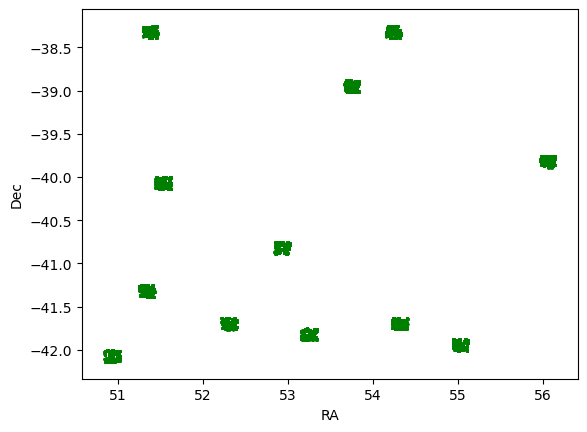

In [57]:
plt.scatter(truth_cat_df['ra'], truth_cat_df['dec'], s=1, c=['green'])
plt.xlabel('RA')
plt.ylabel('Dec')

(-38.225, -38.4)

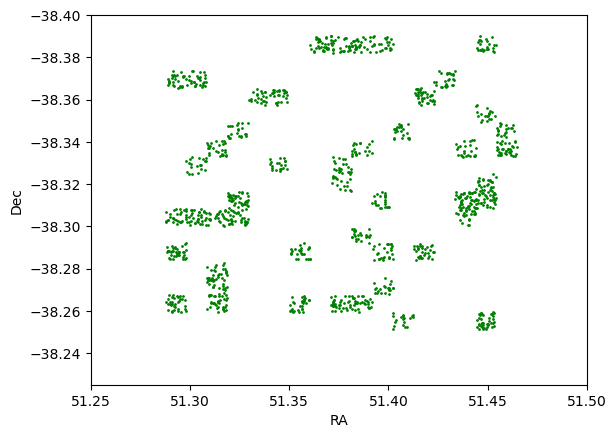

In [58]:
## zooming into a single subpatch
plt.scatter(truth_cat_df['ra'], truth_cat_df['dec'], s=1, c=['green'])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)

Text(0, 0.5, 'Dec')

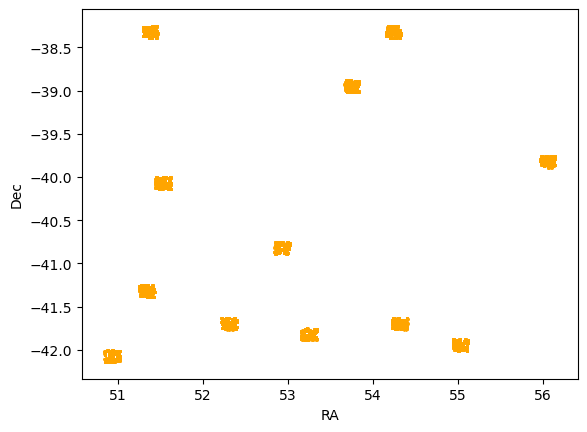

In [62]:
plt.scatter(dd_det_cat_df['ra'], dd_det_cat_df['dec'], s=1, c=['orange'])
plt.xlabel('RA')
plt.ylabel('Dec')

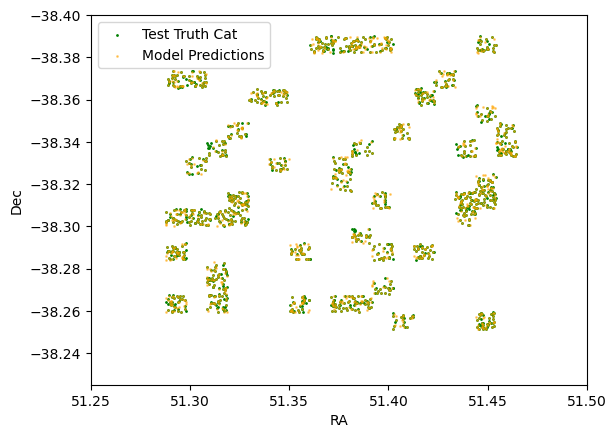

In [15]:
plt.scatter(truth_cat_df['ra'], truth_cat_df['dec'], s=1, c=['green'], label='Test Truth Cat')
plt.scatter(dd_det_cat_df['ra'], dd_det_cat_df['dec'], s=1, c=['orange'], label='Model Predictions', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

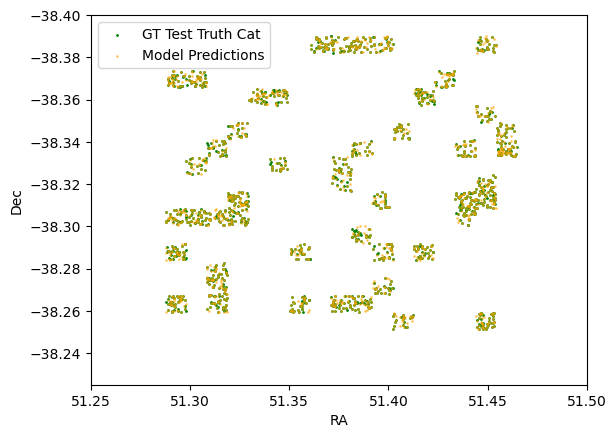

In [19]:
# duplicate cell as this time, 
# truth_cat_df and dd_det_cat_df contained the scaled coords and I didn't want to get rid of the unscaled plots above
plt.scatter(truth_cat_df['ra'], truth_cat_df['dec'], s=1, c=['green'], label='GT Test Truth Cat')
plt.scatter(dd_det_cat_df['ra'], dd_det_cat_df['dec'], s=1, c=['orange'], label='Model Predictions', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

# Getting Subset of Test LSST Det/Truth Cat

In [16]:
def get_lsst_test_cat(test_data, lsst_cat, cat_type):
    if cat_type == 'det':
        lsst_coords = SkyCoord(ra=lsst_cat['ra']*u.deg, dec=lsst_cat['dec']*u.deg)
    else: # truth
        lsst_coords = SkyCoord(ra=lsst_cat['ra_truth_merged']*u.deg, dec=lsst_cat['dec_truth_merged']*u.deg)
    
    all_bounds = []
    truth_info_cache = {}

    for d in test_data:
        imid = d['image_id']
        # temporary sol before I move all the corresponding correct WCS to the ups and pad dirs
        # right now only the truth dir has the updated WCS
        subpatch = d['subpatch']
        if subpatch not in truth_info_cache:
            truth_info_filename = f'./lsst_data/truth/{subpatch}/{subpatch}_info.json'
            with open(truth_info_filename) as json_data:
                truth_info_cache[subpatch] = json.load(json_data)
        
        truth_info = truth_info_cache[subpatch]
        # grab the WCS
        entry = next(entry for entry in truth_info if entry['image_id'] == imid)
        wcs = WCS(entry['wcs'])
        height = entry['height']
        width = entry['width']
        # for entry in truth_info:
        #     if entry['image_id'] == imid:
        #         # print(f'hi {imid}')
        #         wcs = WCS(entry['wcs'])
        #         height = entry['height']
        #         width = entry['width']
        
        # top left (0, 0), top right, bottom left, bottom right (width - 1, height - 1)
        corners = wcs.pixel_to_world([0, width-1, 0, width-1], [0, 0, height-1, height-1])
        all_bounds.append(corners)
        # ra_min, ra_max = (coords_topleft.ra.value, coords_bottomright.ra.value)
        # dec_min, dec_max = (coords_topleft.dec.value, coords_bottomright.dec.value)
        # cutout_coords = SkyCoord(ra=[ra_min, ra_max]*u.deg, dec=[dec_min, dec_max]*u.deg)
    
    mask = np.zeros(len(lsst_coords), dtype=bool)
    for bounds in all_bounds:
        ra_min, ra_max = np.min(bounds.ra), np.max(bounds.ra)
        dec_min, dec_max = np.min(bounds.dec), np.max(bounds.dec)
        
        mask |= ((lsst_coords.ra >= ra_min) & (lsst_coords.ra <= ra_max) &
                 (lsst_coords.dec >= dec_min) & (lsst_coords.dec <= dec_max))
    
    filtered_lsst_det = lsst_cat[mask]
    # print(len(filtered_lsst_det))
    if cat_type == 'det':
        return filtered_lsst_det.drop_duplicates(subset=['ra', 'dec'])
    
    return filtered_lsst_det.drop_duplicates(subset=['ra_truth_merged', 'dec_truth_merged'])

In [20]:
def get_lsst_test_cat_scaled(test_data, lsst_cat, cat_type):
    if cat_type == 'det':
        lsst_coords = SkyCoord(ra=lsst_cat['ra']*u.deg, dec=lsst_cat['dec']*u.deg)
    else: # truth
        lsst_coords = SkyCoord(ra=lsst_cat['ra_truth_merged']*u.deg, dec=lsst_cat['dec_truth_merged']*u.deg)
    
    all_bounds = []
    truth_info_cache = {}

    for d in test_data:
        imid = d['image_id']
        subpatch = d['subpatch']
        if subpatch not in truth_info_cache:
            truth_info_filename = f'./lsst_data/truth/{subpatch}/{subpatch}_info.json'
            with open(truth_info_filename) as json_data:
                truth_info_cache[subpatch] = json.load(json_data)
        
        truth_info = truth_info_cache[subpatch]
        entry = next(entry for entry in truth_info if entry['image_id'] == imid)
        wcs = WCS(entry['wcs'])
        orig_height, orig_width = entry['height'], entry['width']
        scale_x, scale_y = get_scale_factors(orig_height, orig_width)
        
        # corner coords
        # top left (0,0) top right (511, 0) bottom left (0, 511) bottom right (511, 511)
        corners_x = [0, 511, 0, 511]  # bc upsampled img is 512x512
        corners_y = [0, 0, 511, 511]
        adj_corners_x, adj_corners_y = zip(*[adjust_coordinates(x, y, scale_x, scale_y) for x, y in zip(corners_x, corners_y)])
        corners = wcs.pixel_to_world(adj_corners_x, adj_corners_y)
        all_bounds.append(corners)
    
    mask = np.zeros(len(lsst_coords), dtype=bool)
    for bounds in all_bounds:
        ra_min, ra_max = np.min(bounds.ra), np.max(bounds.ra)
        dec_min, dec_max = np.min(bounds.dec), np.max(bounds.dec)
        
        mask |= ((lsst_coords.ra >= ra_min) & (lsst_coords.ra <= ra_max) &
                 (lsst_coords.dec >= dec_min) & (lsst_coords.dec <= dec_max))
    
    filtered_lsst_det = lsst_cat[mask]
    
    if cat_type == 'det':
        return filtered_lsst_det.drop_duplicates(subset=['ra', 'dec'])
    
    return filtered_lsst_det.drop_duplicates(subset=['ra_truth_merged', 'dec_truth_merged'])

In [17]:
lsst_det = pd.read_json('/home/shared/hsc/roman_lsst/lsst_catalogs/overlap_lsst_det_cat.json')
len(lsst_det)

89879

In [18]:
lsst_truth = pd.read_json('/home/shared/hsc/roman_lsst/lsst_catalogs/overlap_lsst_truth_cat.json')
len(lsst_truth)

89879

In [19]:
lsst_test_det = get_lsst_test_cat(test_data=test_data, lsst_cat=lsst_det, cat_type='det')

In [23]:
lsst_test_det = get_lsst_test_cat_scaled(test_data=test_data, lsst_cat=lsst_det, cat_type='det')

In [223]:
lsst_test_det['mag_i'].describe() 
# so this lsst_test_det is mag i  < 26.4 and it has a mag r < 26.9

count    13733.000000
mean        24.832172
std          1.358451
min         15.349966
25%         24.335623
50%         25.210477
75%         25.761771
max         26.399654
Name: mag_i, dtype: float64

In [20]:
lsst_test_truth = get_lsst_test_cat(test_data=test_data, lsst_cat=lsst_truth, cat_type='truth')

In [24]:
lsst_test_truth = get_lsst_test_cat_scaled(test_data=test_data, lsst_cat=lsst_truth, cat_type='truth')

In [224]:
lsst_test_truth['mag_i'].describe()
# so this lsst_test_truth doesn't have mag cuts  

count    18281.000000
mean        24.929665
std          1.451692
min         11.116846
25%         24.392927
50%         25.368793
75%         25.933535
max         26.439188
Name: mag_i, dtype: float64

In [21]:
len(lsst_test_det), len(lsst_test_truth)

(13733, 18281)

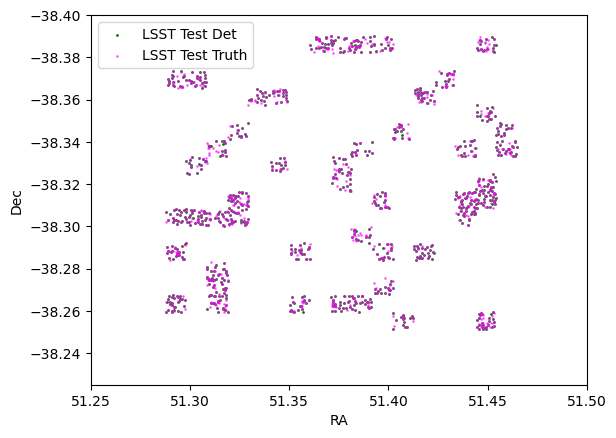

In [22]:
plt.scatter(lsst_test_det['ra'], lsst_test_det['dec'], s=1, c=['green'], label='LSST Test Det')
plt.scatter(lsst_test_truth['ra_truth_merged'], lsst_test_truth['dec_truth_merged'], s=1, c=['magenta'], label='LSST Test Truth', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

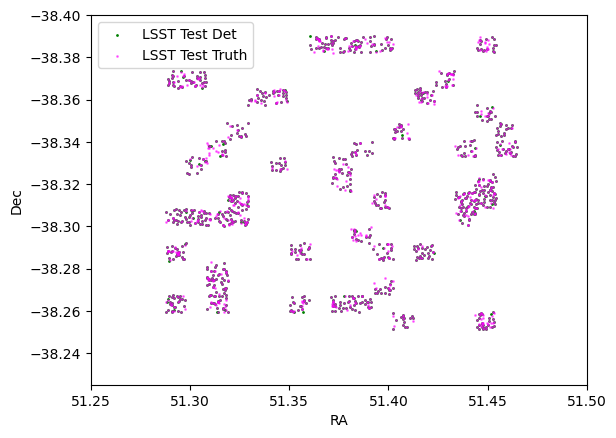

In [27]:
# duplicate cell as this time, 
# truth_cat_df and dd_det_cat_df contained the scaled coords and I didn't want to get rid of the unscaled plots above
plt.scatter(lsst_test_det['ra'], lsst_test_det['dec'], s=1, c=['green'], label='LSST Test Det')
plt.scatter(lsst_test_truth['ra_truth_merged'], lsst_test_truth['dec_truth_merged'], s=1, c=['magenta'], label='LSST Test Truth', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

In [28]:
# lsst_test_det.to_json('/home/yse2/lsst_data/annotations/lsst_test_det_cat.json', orient='records')
lsst_test_det.to_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det_cat.json', orient='records')

In [29]:
# lsst_test_truth.to_json('/home/yse2/lsst_data/annotations/lsst_test_truth_cat.json', orient='records')
lsst_test_truth.to_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth_cat.json', orient='records')

# Reading in Roman Detection Catalog

In [29]:
roman_test_det = pd.read_json('/home/yse2/roman_data/roman_test_det.json')

In [32]:
len(roman_test_det), len(np.unique(roman_test_det['alphawin_j2000'])), len(np.unique(roman_test_det['deltawin_j2000']))

(62178, 62175, 62176)

In [33]:
roman_test_det = roman_test_det.rename(columns={'alphawin_j2000': 'ra', 'deltawin_j2000': 'dec'})

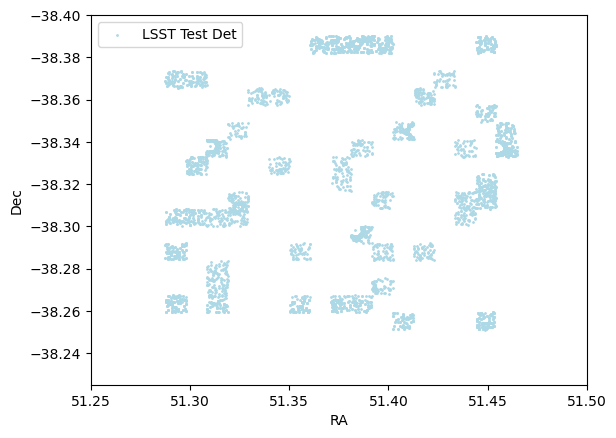

In [38]:
# duplicate cell as this time, 
# truth_cat_df and dd_det_cat_df contained the scaled coords and I didn't want to get rid of the unscaled plots above
plt.scatter(roman_test_det['ra'], roman_test_det['dec'], s=1, c=['lightblue'], label='LSST Test Det')
# plt.scatter(lsst_test_truth['ra_truth_merged'], lsst_test_truth['dec_truth_merged'], s=1, c=['magenta'], label='LSST Test Truth', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

# Detection Completeness

In [5]:
def detection_completeness(dd_det_cat, test_truth_cat, cat_type='lsst_test_truth'):
    ras = dd_det_cat.ra.values
    decs = dd_det_cat.dec.values
    coord = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)
    
    if cat_type == 'gt_test_truth':
        ras_2 = test_truth_cat.ra.values
        decs_2 = test_truth_cat.dec.values
        allcatalog = SkyCoord(ra=ras_2*u.degree, dec=decs_2*u.degree)
    else:    
        ras_2 = test_truth_cat.ra_truth_merged.values
        decs_2 = test_truth_cat.dec_truth_merged.values
        allcatalog = SkyCoord(ra=ras_2*u.degree, dec=decs_2*u.degree)
   
    idx, d2d, d3d = coord.match_to_catalog_sky(allcatalog)
    minds = np.where(d2d.to(u.arcsec).value<=0.5)
    comp = len(minds[0])/len(test_truth_cat)
    return comp

## Detection Completeness with LSST Test Truth Cat

In [99]:
# just LSST images was 77%
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_truth_cat.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_det_cat.json')
dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run2_sm/dd_test_det.json')
detection_completeness(lsst_test_det, lsst_test_truth), "DeepDISC Completeness" , detection_completeness(dd_det_cat_df, lsst_test_truth), 

(0.7330014769432744, 'DeepDISC Completeness', 0.779607242492205)

In [100]:
detection_completeness(dd_det_cat_df, lsst_test_det, cat_type='gt_test_truth')

0.8833466831719217

In [96]:
# just LSST images was 77%
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth_cat.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det_cat.json')
dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det.json')
detection_completeness(lsst_test_det, lsst_test_truth), "DeepDISC Completeness" ,detection_completeness(dd_det_cat_df, lsst_test_truth), 

(0.733700092597636, 'DeepDISC Completeness', 0.8307642028432921)

In [98]:
detection_completeness(dd_det_cat_df, lsst_test_det, cat_type='gt_test_truth')

0.8955666449699863

In [101]:
lsst_test_truth['mag_i'].describe()

count    18281.000000
mean        24.929665
std          1.451692
min         11.116846
25%         24.392927
50%         25.368793
75%         25.933535
max         26.439188
Name: mag_i, dtype: float64

In [103]:
mags = np.arange(min(lsst_test_truth['mag_i'].values), max(lsst_test_truth['mag_i'].values),0.5)
comps = []
for mag in mags:
    small_lsst_truth = lsst_test_truth[(lsst_test_truth['mag_i'] < mag)]
    if len(small_lsst_truth) > 0:
        comp = detection_completeness(dd_det_cat_df, small_lsst_truth)
    else:
        comp = 0
    comps.append(comp)

# grant code
# dcs = []
# for i in range(1,len(mags)):
#     dc = detection_completeness(dd_det,lsst_cut_det.iloc[np.where(np.digitize(lsst_cut_det.mag_i.values, bins=mags)==i)])
#     dcs.append(dc)
# fig, ax = plt.subplots(2,1,figsize=(5,8),sharex=True)
# ax[0].hist(lsst_cut_det.mag_i.values, bins=mags, color='slategrey')
# ax[1].plot(mags[:-1],dcs, color='slategrey')
# ax[1].set_xlabel('mag i',fontsize=15)
# ax[0].set_ylabel('N',fontsize=15)
# ax[1].set_ylabel('Detection completeness',fontsize=15)
# ax[1].tick_params(axis='both', which='major', labelsize=13)
# ax[0].tick_params(axis='both', which='major', labelsize=13)
# plt.tight_layout()
# ax[1].axvline(26.02)
# ax[0].axvline(26.02)

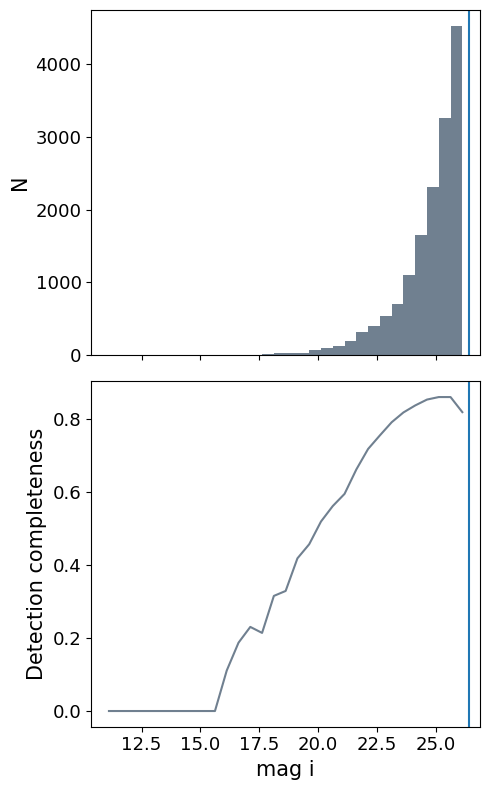

In [104]:
fig, ax = plt.subplots(2,1,figsize=(5,8),sharex=True)
ax[0].hist(lsst_test_truth.mag_i.values, bins=mags, color='slategrey')
ax[1].plot(mags, comps, color='slategrey')
ax[1].set_xlabel('mag i',fontsize=15)
ax[0].set_ylabel('N',fontsize=15)
ax[1].set_ylabel('Detection completeness',fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[0].tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
ax[1].axvline(26.4)
ax[0].axvline(26.4)

## Detection Completeness with Ground Truth Test Truth Cat

In [34]:
# went from 70 with just LSST data to 82% with upsample and added Roman
detection_completeness(dd_det_cat_df, truth_cat_df, cat_type='gt_test_truth')

0.8247268604411462

In [35]:
dd_det_cat_df.to_json(output_dir + '/dd_test_det.json', orient='records')

# 1-1 Matching of Det to Truth

In [69]:
# lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_truth_cat.json')
# lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_det_cat.json')
# dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run2_sm/dd_test_det.json')
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth_cat.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det_cat.json')
dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det.json')

In [95]:
# 2 less than magnitude based on cutoff
lsst_test_truth['mag_i'].describe()

count    18359.000000
mean        24.930973
std          1.450045
min         11.116846
25%         24.395074
50%         25.368793
75%         25.933767
max         26.439188
Name: mag_i, dtype: float64

In [70]:
def match_with_truth(det_cat, truth_cat, max_sep=0.5*u.arcsec):
    """
    Match detection catalog with truth catalog with search around sky
    Only keep 1-to-1 matches within max_sep
    """
    if len(det_cat) == 0:
        return pd.DataFrame(), pd.DataFrame()

    det_coords = SkyCoord(ra=det_cat['ra']*u.deg, 
                         dec=det_cat['dec']*u.deg)
    truth_coords = SkyCoord(ra=truth_cat['ra_truth_merged']*u.deg, 
                           dec=truth_cat['dec_truth_merged']*u.deg)
    
    idx_det, d2d, _ = det_coords.match_to_catalog_sky(truth_coords)
    good_sep = d2d <= max_sep
    # count how many truth objs match to each det and keep 1-to-1 matches
    unique_truth, truth_counts = np.unique(idx_det[good_sep], return_counts=True)
    good_truth = unique_truth[truth_counts == 1]
    
    final_mask = good_sep & np.isin(idx_det, good_truth)
    matched_det_indices = np.where(final_mask)[0]
    matched_truth_indices = idx_det[final_mask]
    
    matched_det = det_cat.iloc[matched_det_indices].copy()
    matched_truth = truth_cat.iloc[matched_truth_indices].copy()
    
    print(f"Found {len(matched_det)} matched pairs")
    
#     print(final_matches)
    return matched_det, matched_truth

In [71]:
len(lsst_test_det), len(lsst_test_truth), len(dd_det_cat_df)

(13827, 18359, 22263)

In [72]:
lsst_test_matched_det, lsst_test_matched_truth = match_with_truth(lsst_test_det, lsst_test_truth)

Found 13461 matched pairs


In [73]:
# lsst_test_matched_det.to_json('/home/yse2/lsst_data/annotations/lsst_test_det11_cat.json', orient='records')
# lsst_test_matched_truth.to_json('/home/yse2/lsst_data/annotations/lsst_test_truth11_cat.json', orient='records')

lsst_test_matched_det.to_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det11_cat.json', orient='records')
lsst_test_matched_truth.to_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth11_cat.json', orient='records')

In [74]:
dd_matched_det, dd_matched_truth = match_with_truth(dd_det_cat_df, lsst_test_truth)

Found 15026 matched pairs


In [3]:
# dd_matched_det.to_json('/home/yse2/lsst_runs/run2_sm/dd_test_det11.json', orient='records')
# dd_matched_truth.to_json('/home/yse2/lsst_runs/run2_sm/dd_test_truth11.json', orient='records')

dd_matched_det.to_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det11.json', orient='records')
dd_matched_truth.to_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_truth11.json', orient='records')

NameError: name 'dd_matched_det' is not defined

In [4]:
dd_matched_det = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det11.json', orient='records')
dd_matched_truth = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_truth11.json', orient='records')

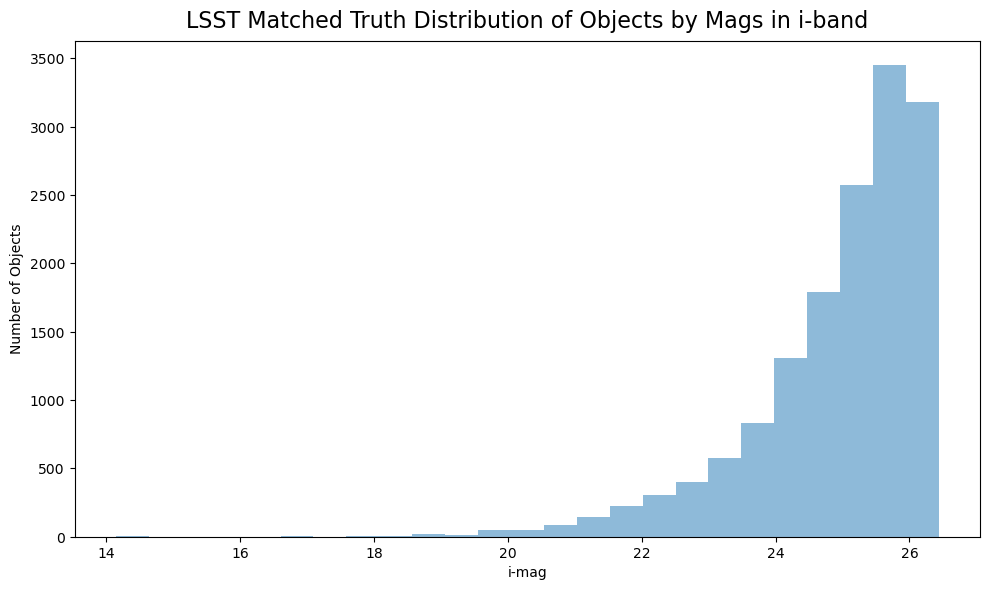

In [92]:
plt.figure(figsize=(10, 6))
plt.ylabel('Number of Objects')
plt.hist(dd_matched_truth['mag_i'], bins=25, label='i-mag', alpha=0.5)
plt.xlabel('i-mag')
plt.title('LSST Matched Truth Distribution of Objects by Mags in i-band', fontsize=16, y=1.01)
plt.tight_layout()

In [93]:
dd_matched_det = pd.read_json('/home/yse2/lsst_runs/run2_sm/dd_test_det11.json', orient='records')
dd_matched_truth = pd.read_json('/home/yse2/lsst_runs/run2_sm/dd_test_truth11.json', orient='records')

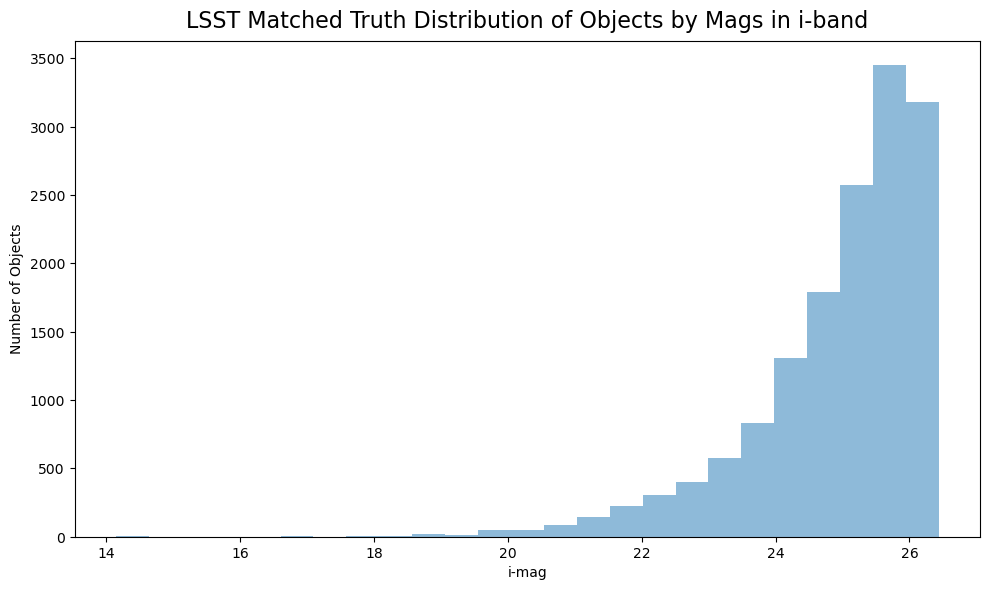

In [5]:
plt.figure(figsize=(10, 6))
plt.ylabel('Number of Objects')
plt.hist(dd_matched_truth['mag_i'], bins=25, label='i-mag', alpha=0.5)
plt.xlabel('i-mag')
plt.title('LSST Matched Truth Distribution of Objects by Mags in i-band', fontsize=16, y=1.01)
plt.tight_layout()

In [7]:
dd_matched_truth.columns

Index(['flux_i', 'cosmodc2_hp', 'flux_r', 'patch', 'truth_type', 'flux_z',
       'cosmodc2_id', 'tract', 'mag_y', 'mag_r', 'flux_u', 'mag_z',
       'dec_truth_merged', 'id_string', 'ra_truth_merged', 'flux_y',
       'redshift_truth_merged', 'flux_g', 'mag_i', 'id', 'mag_g', 'mag_u',
       'ellipticity_1_disk_true', 'shear_1', 'ellipticity_1_true',
       'LSST_filters/diskLuminositiesStellar:LSST_y:observed', 'A_v',
       'mag_true_y', 'size_bulge_true', 'mag_true_i', 'bulge_to_total_ratio_i',
       'size_minor_true', 'size_minor_disk_true', 'size_true',
       'ellipticity_2_bulge_true', 'ellipticity_1_bulge_true', 'mag_true_g',
       'mag_true_r', 'ellipticity_2_disk_true',
       'LSST_filters/diskLuminositiesStellar:LSST_u:observed', 'convergence',
       'R_v', 'mag_true_z', 'size_minor_bulge_true', 'size_disk_true',
       'dec_cosmodc2', 'ellipticity_2_true', 'position_angle_true_dc2',
       'ra_cosmodc2', 'mag_true_u', 'redshift_cosmodc2',
       'LSST_filters/spheroidL

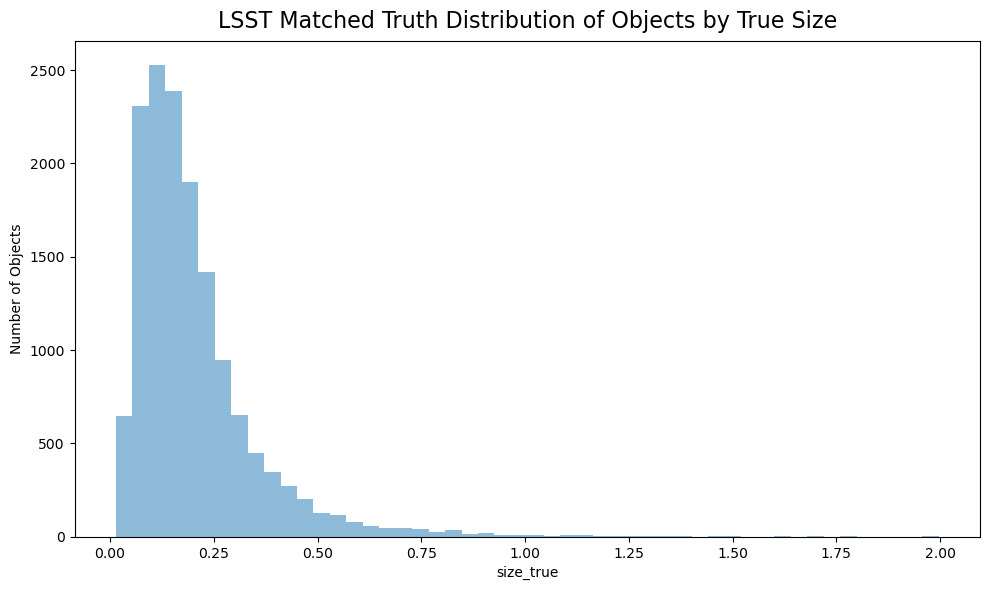

In [11]:
plt.figure(figsize=(10, 6))
plt.ylabel('Number of Objects')
plt.hist(dd_matched_truth['size_true'], bins=50, label='i-mag', alpha=0.5)
plt.xlabel('size_true')
plt.title('LSST Matched Truth Distribution of Objects by True Size', fontsize=16, y=1.01)
plt.tight_layout()

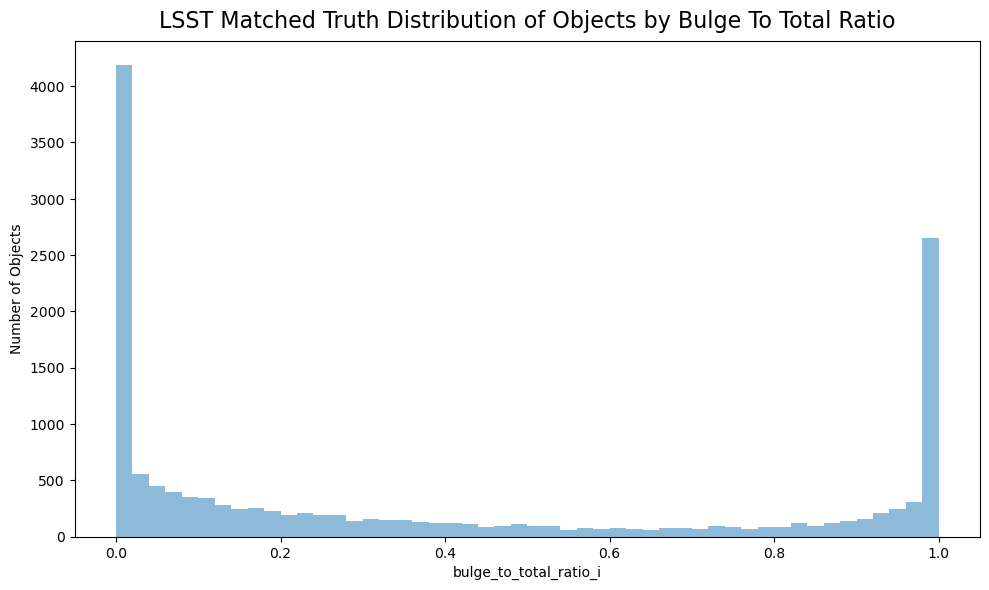

In [14]:
plt.figure(figsize=(10, 6))
plt.ylabel('Number of Objects')
plt.hist(dd_matched_truth['bulge_to_total_ratio_i'], bins=50, label='i-mag', alpha=0.5)
plt.xlabel('bulge_to_total_ratio_i')
plt.title('LSST Matched Truth Distribution of Objects by Bulge To Total Ratio', fontsize=16, y=1.01)
plt.tight_layout()

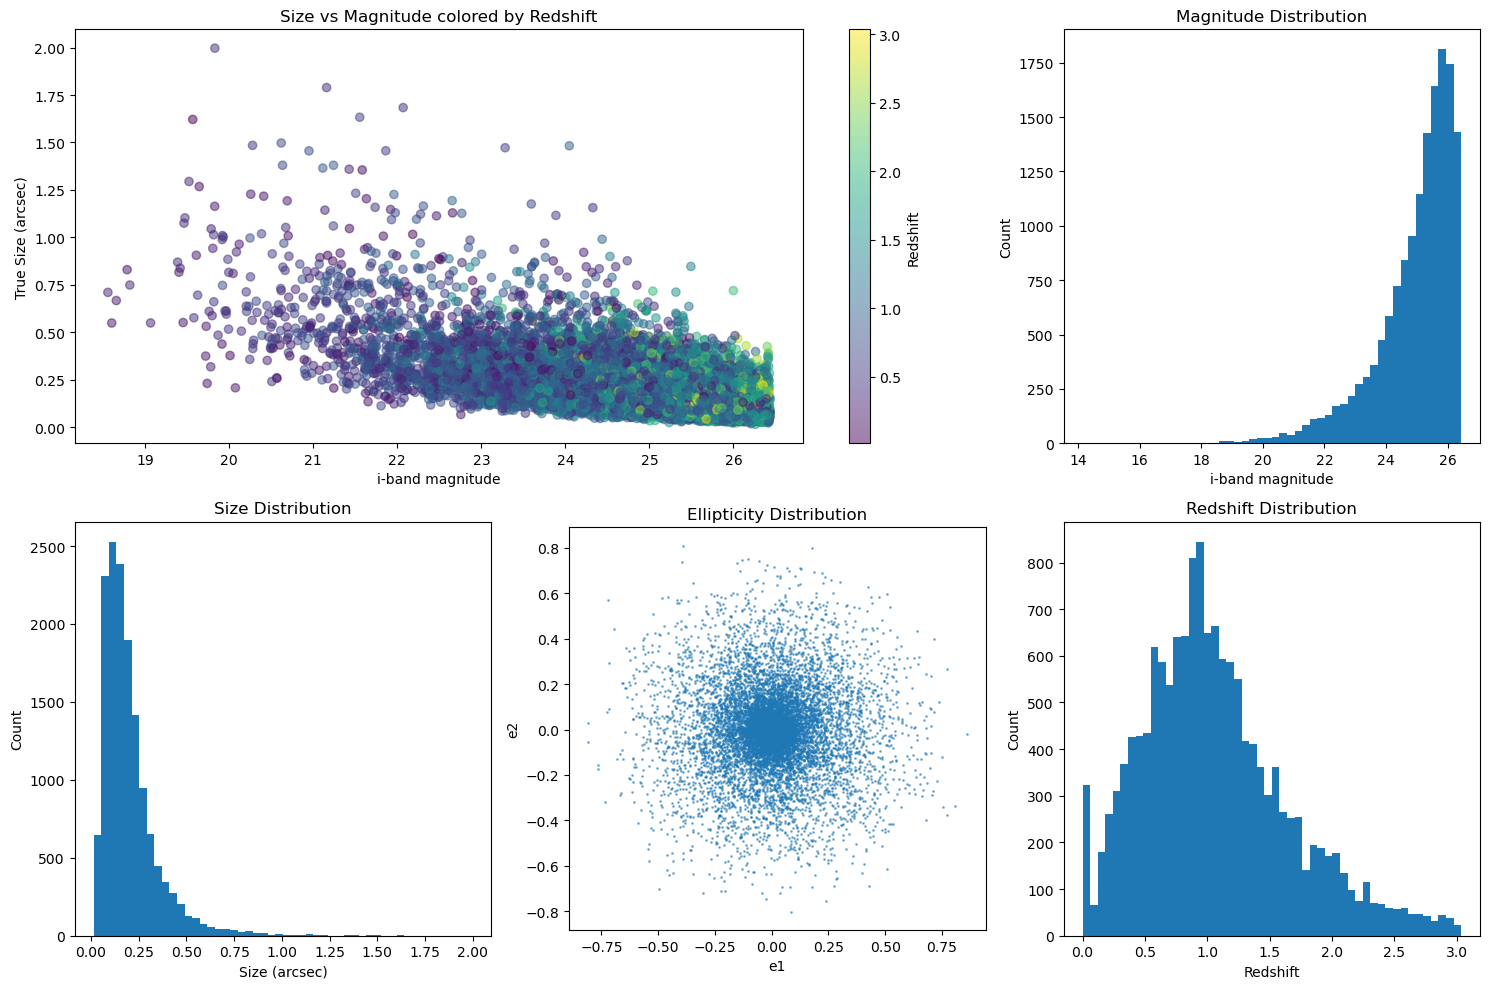

In [16]:
import seaborn as sns
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig)

# Size vs magnitude scatter
ax1 = fig.add_subplot(gs[0, :2])
scatter = ax1.scatter(dd_matched_truth['mag_i'], 
                     dd_matched_truth['size_true'],
                     c=dd_matched_truth['redshift_truth_merged'],
                     alpha=0.5, cmap='viridis')
ax1.set_xlabel('i-band magnitude')
ax1.set_ylabel('True Size (arcsec)')
ax1.set_title('Size vs Magnitude colored by Redshift')
plt.colorbar(scatter, ax=ax1, label='Redshift')
# Blue/purple colors represent lower redshifts (closer objects)
# Yellow/green colors represent higher redshifts (more distant objects)

# Magnitude histogram
ax2 = fig.add_subplot(gs[0, 2])
ax2.hist(dd_matched_truth['mag_i'], bins=50)
ax2.set_xlabel('i-band magnitude')
ax2.set_ylabel('Count')
ax2.set_title('Magnitude Distribution')

# Size histogram
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(dd_matched_truth['size_true'], bins=50)
ax3.set_xlabel('Size (arcsec)')
ax3.set_ylabel('Count')
ax3.set_title('Size Distribution')

# Ellipticity distribution
ax4 = fig.add_subplot(gs[1, 1])
e1 = dd_matched_truth['ellipticity_1_true']
e2 = dd_matched_truth['ellipticity_2_true']
ax4.scatter(e1, e2, alpha=0.5, s=1)
ax4.set_xlabel('e1')
ax4.set_ylabel('e2')
ax4.set_title('Ellipticity Distribution')
ax4.set_aspect('equal')

# Redshift histogram
ax5 = fig.add_subplot(gs[1, 2])
ax5.hist(dd_matched_truth['redshift_truth_merged'], bins=50)
ax5.set_xlabel('Redshift')
ax5.set_ylabel('Count')
ax5.set_title('Redshift Distribution')

plt.tight_layout()

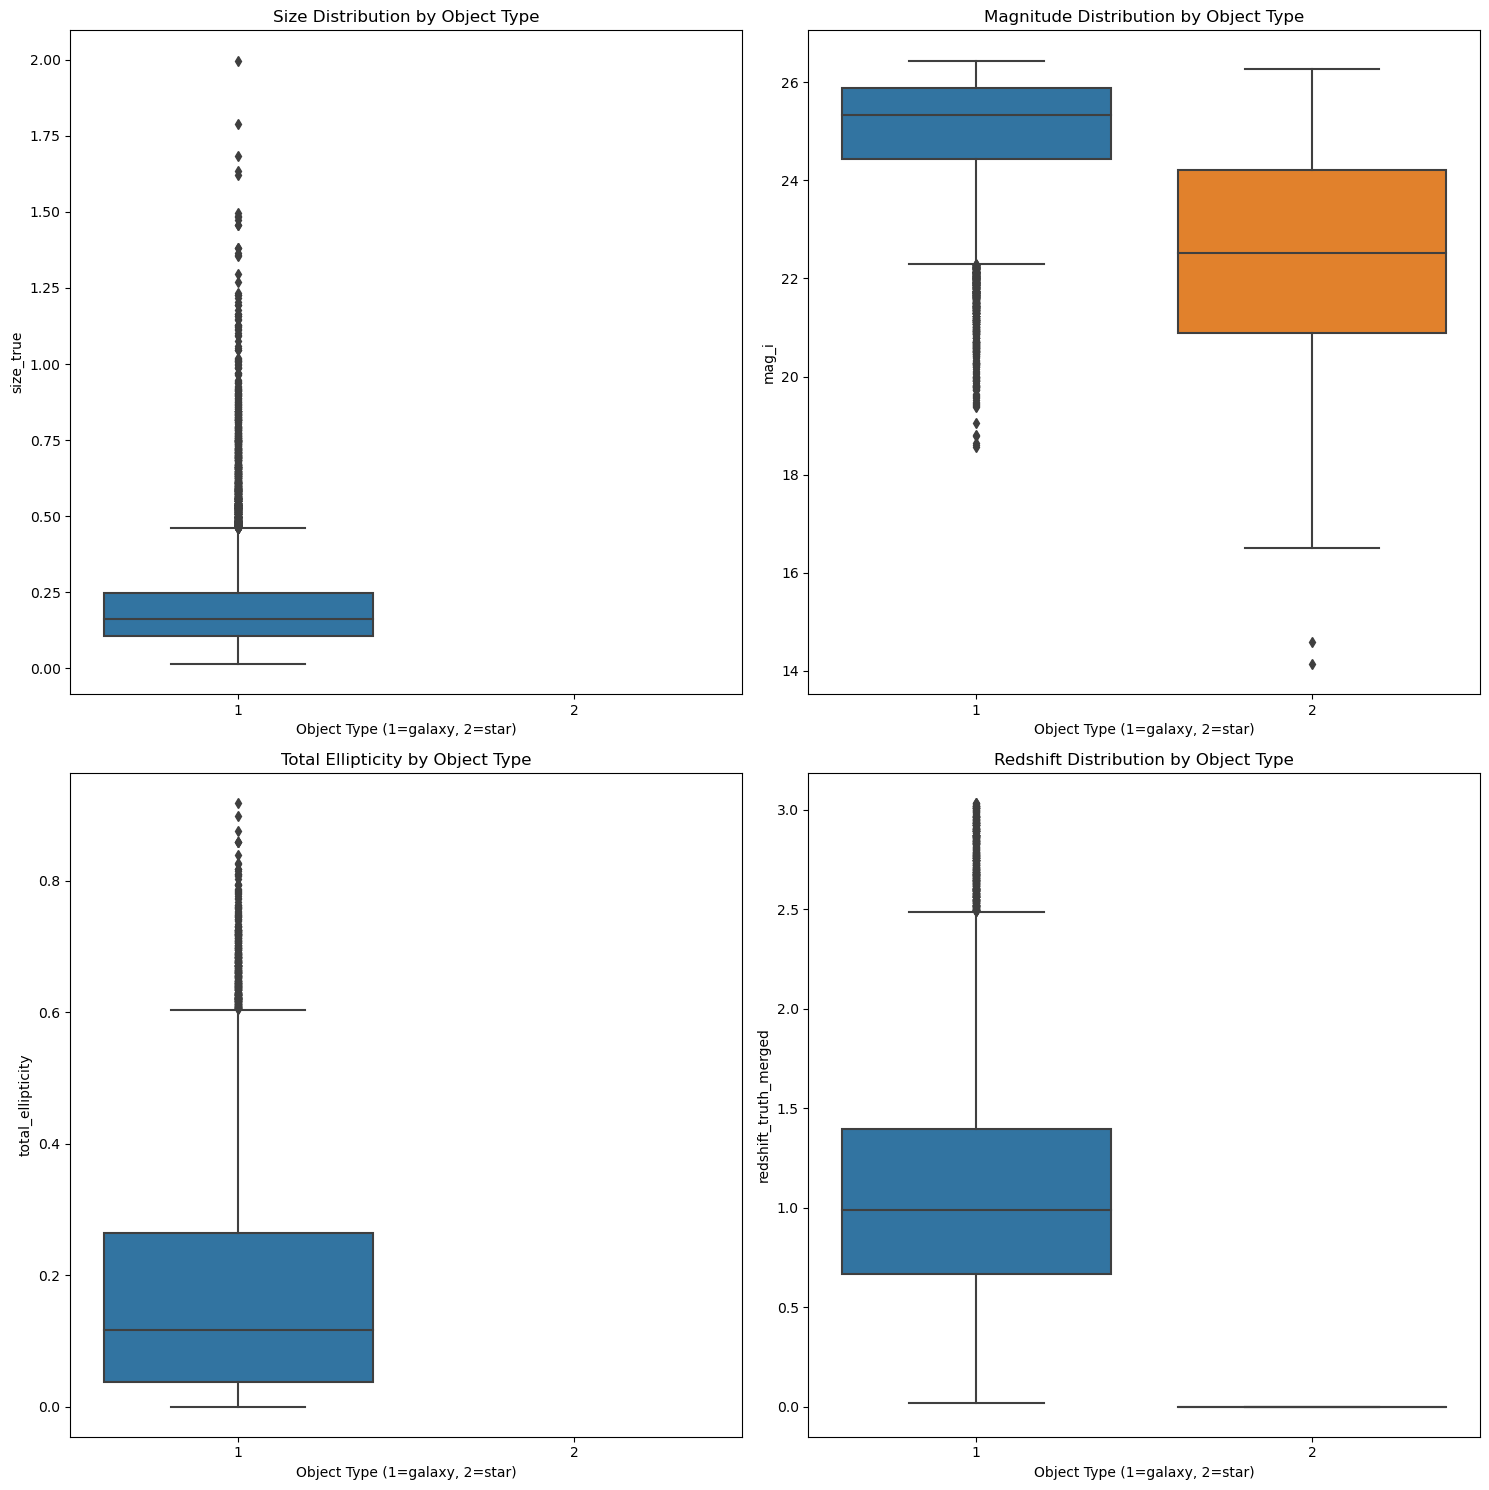

In [18]:
 fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
# Size by type
sns.boxplot(data=dd_matched_truth, x='truth_type', y='size_true', ax=axes[0,0])
axes[0,0].set_title('Size Distribution by Object Type')
axes[0,0].set_xlabel('Object Type (1=galaxy, 2=star)')

# Magnitude by type
sns.boxplot(data=dd_matched_truth, x='truth_type', y='mag_i', ax=axes[0,1])
axes[0,1].set_title('Magnitude Distribution by Object Type')
axes[0,1].set_xlabel('Object Type (1=galaxy, 2=star)')

# Total ellipticity by type
e_tot = np.sqrt(dd_matched_truth['ellipticity_1_true']**2 + 
                dd_matched_truth['ellipticity_2_true']**2)
dd_matched_truth['total_ellipticity'] = e_tot
sns.boxplot(data=dd_matched_truth, x='truth_type', y='total_ellipticity', ax=axes[1,0])
axes[1,0].set_title('Total Ellipticity by Object Type')
axes[1,0].set_xlabel('Object Type (1=galaxy, 2=star)')

# Redshift by type
sns.boxplot(data=dd_matched_truth, x='truth_type', y='redshift_truth_merged', ax=axes[1,1])
axes[1,1].set_title('Redshift Distribution by Object Type')
axes[1,1].set_xlabel('Object Type (1=galaxy, 2=star)')

plt.tight_layout()

# Unrecognized Blend Fraction

## Loading in the Catalogs

In [20]:
# does same mag cut to truth that detection also has
def get_lsst_cat_ras_decs(lsst_cat, cat_type):
    lsst_df = pd.DataFrame()
    ra_dec_df = None
    if cat_type == 'truth':
        lsst_df = lsst_cat[(lsst_cat['mag_i'] < 27)]
        ra_dec_df = lsst_df[['ra_truth_merged','dec_truth_merged']]
        ra_dec_df = ra_dec_df.rename(columns={'ra_truth_merged': 'ra', 'dec_truth_merged': 'dec'})
        mags = lsst_df['mag_i']
    else: # det catalog
        lsst_df = lsst_cat[(lsst_cat['mag_i'] < 27)]
        ra_dec_df = lsst_df[['ra','dec']]
        mags = lsst_df['mag_i']
    return Table.from_pandas(ra_dec_df), list(mags)

In [21]:
def get_roman_cat_ras_decs(roman_cat, cat_type):
    roman_df = pd.DataFrame()
    ra_dec_df = None
    if cat_type == 'truth':
        print("None")
#         lsst_df = lsst_cat[(lsst_cat['mag_i'] < 27) & (lsst_cat['mag_r'] < 26.9)]
#         ra_dec_df = lsst_df[['ra_truth_merged','dec_truth_merged']]
#         ra_dec_df = ra_dec_df.rename(columns={'ra_truth_merged': 'ra', 'dec_truth_merged': 'dec'})
#         mags = lsst_df['mag_i']
    else: # det catalog
        roman_df = roman_cat[(roman_cat['mag_auto_H158'] < 25.42)]
        ra_dec_df = roman_df[['alphawin_j2000','deltawin_j2000']]
        ra_dec_df = ra_dec_df.rename(columns={'alphawin_j2000': 'ra', 'deltawin_j2000': 'dec'})
        mags = roman_df['mag_auto_H158']
    return Table.from_pandas(ra_dec_df), list(mags)

## Non-Combined Data

### Loading in LSST Det and LSST Truth

In [110]:
lsst_det = pd.read_json('/home/shared/hsc/roman_lsst/lsst_catalogs/overlap_lsst_det_cat.json')
# already loaded in # Getting Subset of Test LSST Truth but can load again here
lsst_truth = pd.read_json('/home/shared/hsc/roman_lsst/lsst_catalogs/overlap_lsst_truth_cat.json') 

In [111]:
len(lsst_truth['ra_truth_merged'].values), len(np.unique(lsst_truth['ra_truth_merged'].values))

(89879, 89879)

In [112]:
len(lsst_det['ra'].values), len(np.unique(lsst_det['ra'].values))

(89879, 67526)

In [113]:
lsst_det = lsst_det.drop_duplicates(subset=['ra', 'dec'])

In [119]:
lsst_det_table, det_mags = get_lsst_cat_ras_decs(lsst_det, cat_type='det')
lsst_truth_table, truth_mags = get_lsst_cat_ras_decs(lsst_truth, cat_type='truth')

In [120]:
len(lsst_det_table), len(lsst_truth_table)

(67526, 89879)

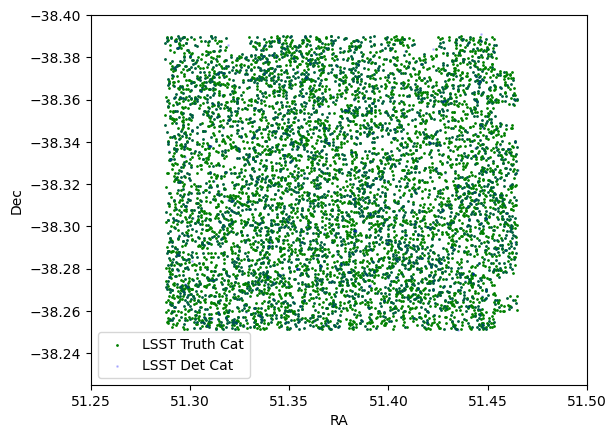

In [24]:
plt.scatter(lsst_truth_table['ra'], lsst_truth_table['dec'], s=1, c=['green'], label='LSST Truth Cat')
plt.scatter(lsst_det_table['ra'], lsst_det_table['dec'], s=1, c=['blue'], label='LSST Det Cat', alpha=0.2)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

### Loading in LSST Test Det and LSST Test Truth

In [24]:
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_truth_cat.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_det_cat.json') 

In [25]:
lsst_test_truth_table, truth_mags = get_lsst_cat_ras_decs(lsst_test_truth, cat_type='truth')
lsst_test_det_table, det_mags = get_lsst_cat_ras_decs(lsst_test_det, cat_type='det')

In [26]:
len(lsst_test_truth_table), len(lsst_test_det_table)

(18145, 7373)

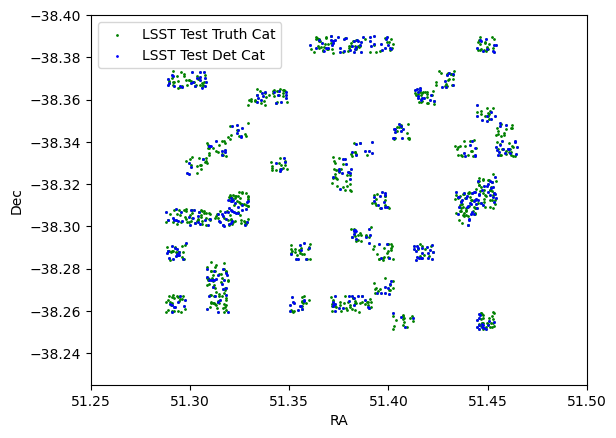

In [27]:
plt.scatter(lsst_test_truth_table['ra'], lsst_test_truth_table['dec'], s=1, c=['green'], label='LSST Test Truth Cat')
plt.scatter(lsst_test_det_table['ra'], lsst_test_det_table['dec'], s=1, c=['blue'], label='LSST Test Det Cat')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

### Loading in DeepDISC Det and Corresponding LSST Truth

In [71]:
dd_test_det = pd.read_json('/home/yse2/lsst_runs/run2_sm/dd_test_det.json')
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_truth_cat.json')

dd_det_table = Table.from_pandas(dd_test_det)
lsst_test_truth_table, test_truth_mags = get_lsst_cat_ras_decs(lsst_test_truth, cat_type='truth')


In [72]:
len(lsst_test_truth_table), len(dd_det_table)

(18145, 20426)

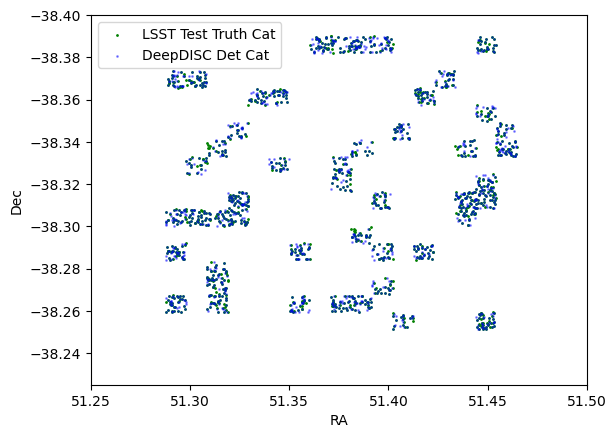

In [30]:
plt.scatter(lsst_test_truth_table['ra'], lsst_test_truth_table['dec'], s=1, c=['green'], label='LSST Test Truth Cat')
plt.scatter(dd_det_table['ra'], dd_det_table['dec'], s=1, c=['blue'], label='DeepDISC Det Cat', alpha=0.4)
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend(loc='best')

### Loading in DeepDISC Det and Corresponding LSST Det

In [55]:
dd_test_det = pd.read_json('/home/yse2/lsst_runs/run2_sm/dd_test_det.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_det_cat.json')

lsst_test_det = lsst_test_det.drop_duplicates(subset=['ra', 'dec'])

dd_det_table = Table.from_pandas(dd_test_det)
lsst_test_det_table, test_det_mags = get_lsst_cat_ras_decs(lsst_test_det, cat_type='det')

In [56]:
len(lsst_test_det_table), len(dd_det_table)

(13733, 20426)

## Combined with Roman

### Loading in LSST Test Det and LSST Test Truth

In [10]:
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth_cat.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det_cat.json') 

In [11]:
lsst_test_truth_table, truth_mags = get_lsst_cat_ras_decs(lsst_test_truth, cat_type='truth')
lsst_test_det_table, det_mags = get_lsst_cat_ras_decs(lsst_test_det, cat_type='det')

In [12]:
len(lsst_test_truth_table), len(lsst_test_det_table)

(18359, 13827)

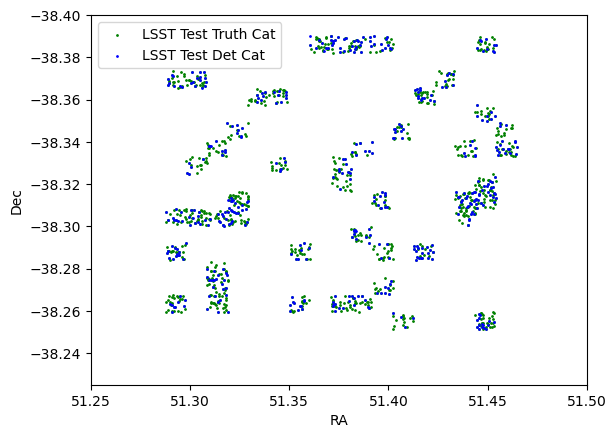

In [47]:
# for combined data
plt.scatter(lsst_test_truth_table['ra'], lsst_test_truth_table['dec'], s=1, c=['green'], label='LSST Test Truth Cat')
plt.scatter(lsst_test_det_table['ra'], lsst_test_det_table['dec'], s=1, c=['blue'], label='LSST Test Det Cat')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

### Loading Roman Test Det and LSST Test Det

In [20]:
roman_test_det = pd.read_json('/home/yse2/roman_data/roman_test_det.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det_cat.json') 
# roman_truth = pd.read_json('/home/shared/hsc/roman_lsst/lsst_catalogs/overlap_lsst_truth_cat.json') 

In [21]:
len(roman_test_det), len(np.unique(roman_test_det['alphawin_j2000'])), len(np.unique(roman_test_det['deltawin_j2000']))

(62178, 62175, 62176)

In [22]:
len(lsst_test_det['ra'].values), len(np.unique(lsst_test_det['ra'].values))

(13827, 13827)

In [23]:
roman_test_det_table, rdet_mags = get_roman_cat_ras_decs(roman_test_det, cat_type='det')
lsst_test_det_table, det_mags = get_lsst_cat_ras_decs(lsst_test_det, cat_type='det')

### Loading in DeepDISC Det and Corresponding LSST Truth

In [13]:
dd_test_det = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det.json')
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth_cat.json')

dd_det_table = Table.from_pandas(dd_test_det)
lsst_test_truth_table, test_truth_mags = get_lsst_cat_ras_decs(lsst_test_truth, cat_type='truth')

In [14]:
len(lsst_test_truth_table), len(dd_det_table)

(18359, 22263)

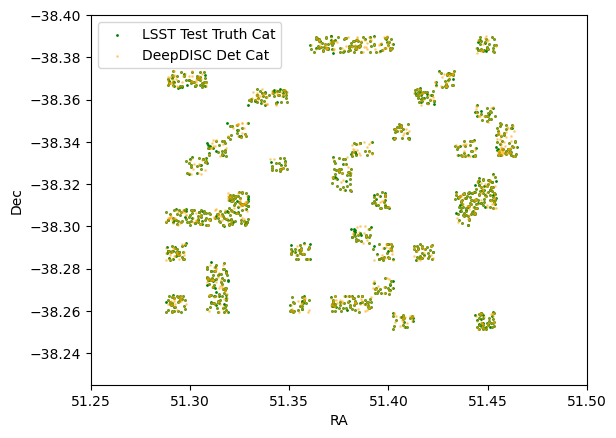

In [51]:
plt.scatter(lsst_test_truth_table['ra'], lsst_test_truth_table['dec'], s=1, c=['green'], label='LSST Test Truth Cat')
plt.scatter(dd_det_table['ra'], dd_det_table['dec'], s=1, c=['orange'], label='DeepDISC Det Cat', alpha=0.4)
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend(loc='best')

### Loading in DeepDISC Det and Corresponding LSST Det

In [24]:
dd_test_det = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det_cat.json')

lsst_test_det = lsst_test_det.drop_duplicates(subset=['ra', 'dec'])

dd_det_table = Table.from_pandas(dd_test_det)
lsst_test_det_table, test_det_mags = get_lsst_cat_ras_decs(lsst_test_det, cat_type='det')

In [25]:
len(lsst_test_det_table), len(dd_det_table)

(13827, 22263)

In [22]:
dd_test_det = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det11.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det11_cat.json')

lsst_test_det = lsst_test_det.drop_duplicates(subset=['ra', 'dec'])

dd_det_table = Table.from_pandas(dd_test_det)
lsst_test_det_table, test_det_mags = get_lsst_cat_ras_decs(lsst_test_det, cat_type='det')

In [23]:
len(lsst_test_det_table), len(dd_det_table)

(13461, 15026)

## Using FOF Catalog Matching

In [24]:
import FoFCatalogMatching
# points within 1 arcsecs of each other are grouped together only if there's no more than 3 friends within 1 arcsec
# None following distance means points are grouped together without any constraint on number of friends
def find_matches(cat_a, cat_b, cat_a_name, cat_b_name, linking_length=1.0, max_friends=1):
    """
    Find matches between two catalogs using Friends-of-Friends algorithm.
    
    Parameters:
    -----------
    cat_a, cat_b : astropy.table.Table
        The two catalogs to match.
    cat_a_name, cat_b_name : str
        Names for the two catalogs.
    linking_length : float, optional
        The linking length in arcseconds. Default is 0.5.
    max_friends : int or None, optional
        The maximum number of friends allowed in a group. 
        Use None for no limit. Default is 1.
    
    Returns:
    --------
    astropy.table.Table
        Matched catalog with group IDs.
    """
    # first linking length groups points within that distance, limited by max_friends
    linking_lengths = {linking_length: max_friends}
    # use lsst truth catalog to get 1-1 match with LSST Det/Roman Det to recreat Fig 11 from Troxel Paper     
    return FoFCatalogMatching.match({cat_a_name: cat_a, cat_b_name: cat_b},
                               linking_lengths)

## Non-Combined

### Comparing LSST DET VS LSST TRUTH

In [121]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_truth'
cat_b_name = 'lsst_det'
lsst_det_lsst_truth05 = find_matches(cat_a=lsst_truth_table, cat_b=lsst_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)
lsst_det_lsst_truth1 = find_matches(cat_a=lsst_truth_table, cat_b=lsst_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=1.0)

In [28]:
lsst_det_lsst_truth05

row_index,catalog_key,group_id
int64,str10,int64
0,lsst_truth,0
0,lsst_det,0
1,lsst_truth,1
1,lsst_det,1
2,lsst_truth,2
2,lsst_det,2
3,lsst_truth,3
3,lsst_det,3
4,lsst_truth,4


### Comparing LSST Test Det vs LSST Test Truth

In [260]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_test_truth'
cat_b_name = 'lsst_test_det'
lsst_truth_lsst_det = find_matches(cat_a=lsst_test_truth_table, cat_b=lsst_test_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
lsst_truth_lsst_det05 = find_matches(cat_a=lsst_test_truth_table, cat_b=lsst_test_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

### Comparing DeepDISC Det VS LSST Truth

In [35]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_test_truth'
cat_b_name = 'dd_det'
dd_det_lsst_truth1 = find_matches(cat_a=lsst_test_truth_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
dd_det_lsst_truth05 = find_matches(cat_a=lsst_test_truth_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

### Comparing DeepDISC Det vs LSST Det

In [57]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_test_det'
cat_b_name = 'dd_det'
dd_det_lsst_det1 = find_matches(cat_a=lsst_test_det_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
dd_det_lsst_det05 = find_matches(cat_a=lsst_test_det_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

## Combined with Roman

### Comparing LSST Test Det vs LSST Test Truth

In [63]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_test_truth'
cat_b_name = 'lsst_test_det'
lsst_truth_lsst_det = find_matches(cat_a=lsst_test_truth_table, cat_b=lsst_test_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
lsst_truth_lsst_det05 = find_matches(cat_a=lsst_test_truth_table, cat_b=lsst_test_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

### Comparing Roman Test Det vs LSST Test Det

In [27]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_test_det'
cat_b_name = 'roman_test_det'
roman_det_lsst_det1 = find_matches(cat_a=lsst_test_det_table, cat_b=roman_test_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
roman_det_lsst_det05 = find_matches(cat_a=lsst_test_det_table, cat_b=roman_test_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

### Comparing DeepDISC Det VS LSST Truth

In [56]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_test_truth'
cat_b_name = 'dd_det'
dd_det_lsst_truth1 = find_matches(cat_a=lsst_test_truth_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
dd_det_lsst_truth05 = find_matches(cat_a=lsst_test_truth_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

### Comparing DeepDISC Det vs LSST Det

In [25]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_test_det'
cat_b_name = 'dd_det'
dd_det_lsst_det1 = find_matches(cat_a=lsst_test_det_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
dd_det_lsst_det05 = find_matches(cat_a=lsst_test_det_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

## Plotting FOF 2D Histograms

In [83]:
def autofit_text(ax, text, x, y):
    fontsize = 11
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="none", alpha=0)

    while fontsize > 1:
        t = ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, 
                    color='white', bbox=bbox_props)
        
        # grab the renderer
        r = ax.figure.canvas.get_renderer()
        bb = t.get_window_extent(renderer=r).transformed(ax.transData.inverted())
        
        # check if text fits within the cell
        if bb.width < 1 and bb.height < 1:
            return
        
        t.remove()
        fontsize -= 1

    # if we got here, text is too large to fit at any readable size
    ax.text(x, y, '.', ha='center', va='center', fontsize=8, color='white')

In [84]:
# Adapted from https://nbviewer.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/matching_fof.nbconvert.ipynb
def plot_matches(results, x_axis_name, xlabel, ylabel):
    # now we want to count the number of cat a and cat b objects *for each group*
    # but instead of looping over groups, we can do this

    # first we need to know which rows are from the x-axis cat (catalog A) and which are from y-axis cat (catalog B)
    cat_a_mask = results['catalog_key'] == x_axis_name
    cat_b_mask = ~cat_a_mask

    # then np.bincount will give num of id occurrences in each group (like historgram but with int input)
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    # print(n_truth[n_truth>10])
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    # unique, counts = np.unique(n_a, return_counts=True)
    # print("n_a:", dict(zip(unique, counts)))
    # unique2, counts2 = np.unique(n_b, return_counts=True)
    # print("n_b:", dict(zip(unique2, counts2)))

    # now n_a and n_b are the number of cat a/cat b objects in each group
    # we want to make a 2d histrogram of (n_a, n_b). 
    n_max = max(n_a.max(), n_b.max()) + 1
    hist_2d = np.bincount(n_b * n_max + n_a, minlength=n_max*n_max).reshape(n_max, n_max) # how we want to visualize our histograms
    # hist_2d = np.bincount(n_b * n_max + n_a, minlength=n_max*n_max).reshape(n_max, n_max) # how they choose to visualize their histograms
    plt.figure(figsize=(12,10))
    plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower', cmap='Oranges')
    plt.xlabel(f'Number of {xlabel}')
    plt.ylabel(f'Number of {ylabel}')
    plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$')
    ax = plt.gca()
    for i in range(n_max):
        for j in range(n_max):
            if hist_2d[i, j] > 0:
                text = str(hist_2d[i, j])
                autofit_text(ax, text, j, i)

In [27]:
def 
cat_a_mask = results['catalog_key'] == 'lsst_test_det'
cat_b_mask = ~cat_a_mask

# then np.bincount will give num of id occurrences in each group (like historgram but with int input)
n_groups = results['group_id'].max() + 1
n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
# print(n_truth[n_truth>10])
n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)

# let's go with the convention that we have LSST Det/Truth on the x-axis (cat_a)
specific_section_mask = (n_a == 0) & (n_b == 1) # where 
# group_ids for LSST objects only
lsst_group_ids = results['group_id'][cat_a_mask]
# mask for blended LSST objects
lsst_blend_mask = np.isin(lsst_group_ids, np.where(blend_mask)[0])

NameError: name 'results' is not defined

## Non-Combined

### LSST Det vs LSST Truth

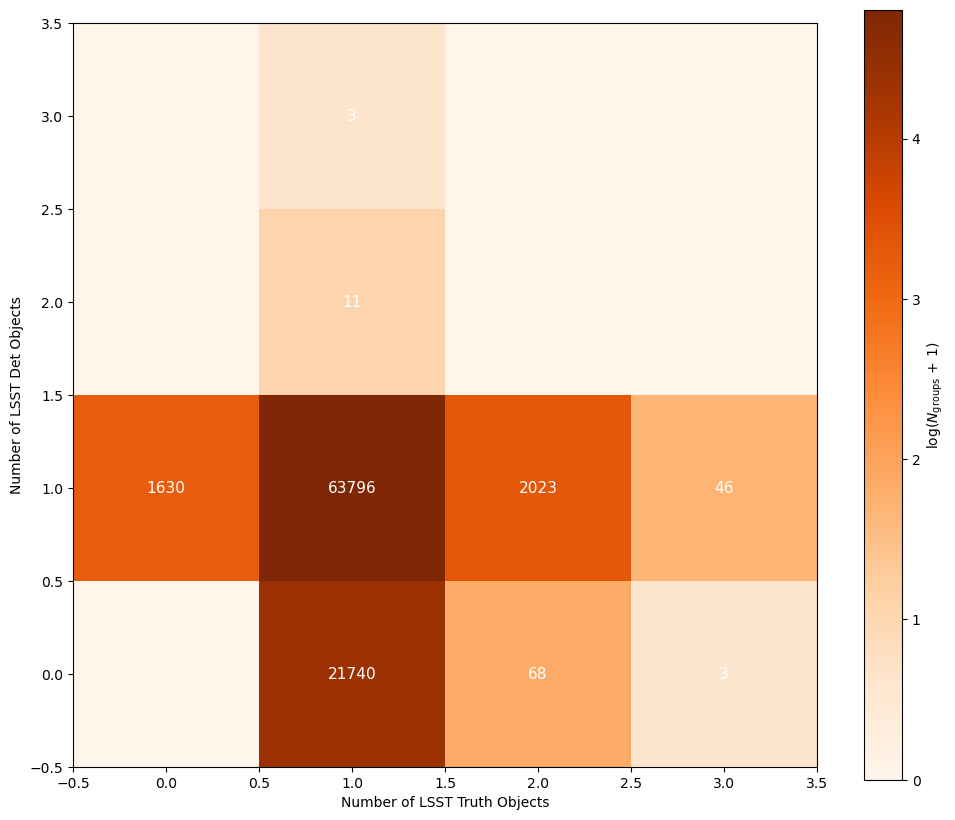

In [122]:
plot_matches(lsst_det_lsst_truth05, x_axis_name='lsst_truth', xlabel='LSST Truth Objects', ylabel='LSST Det Objects')

### LSST Test Det vs LSST Test Truth

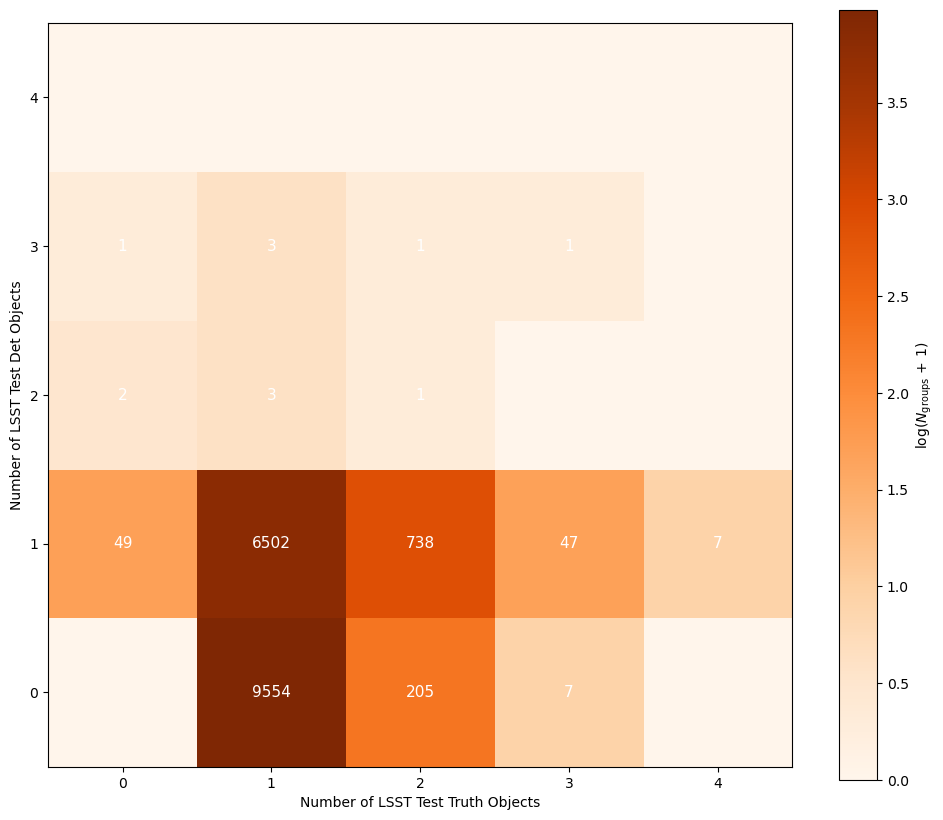

In [262]:
plot_matches(lsst_truth_lsst_det, x_axis_name='lsst_test_truth', xlabel='LSST Test Truth Objects', ylabel='LSST Test Det Objects')

### DeepDISC Det vs LSST Truth 

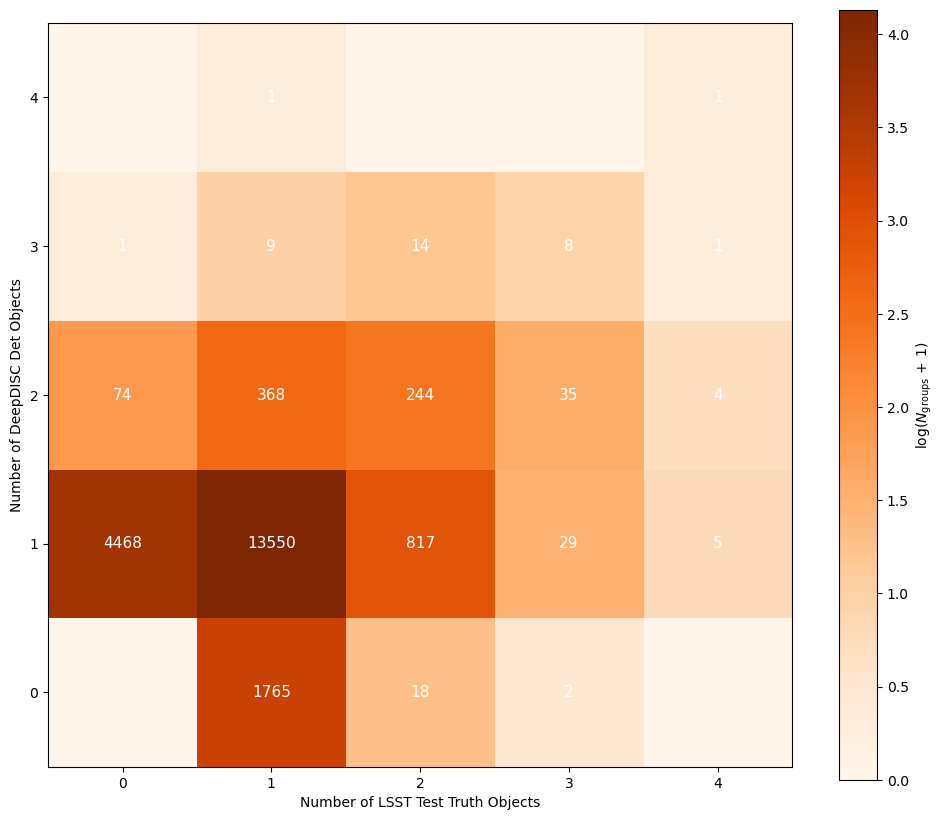

In [277]:
plot_matches(dd_det_lsst_truth1, x_axis_name='lsst_test_truth', xlabel='LSST Test Truth Objects', ylabel='DeepDISC Det Objects')

### DeepDISC Det vs LSST Det

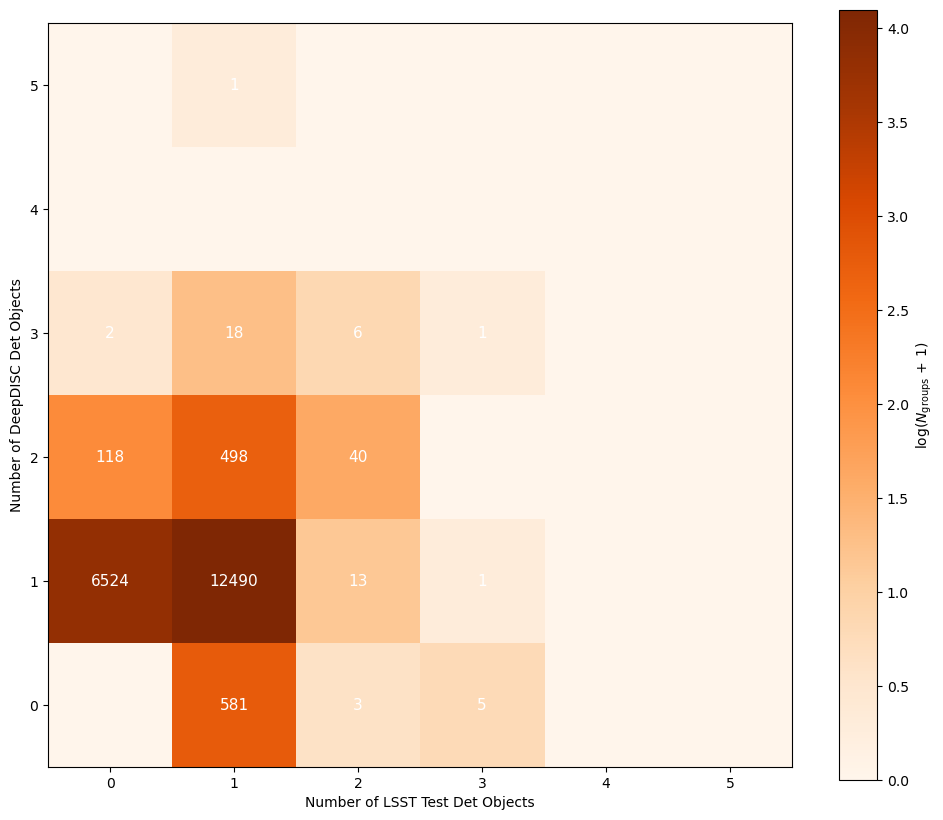

In [58]:
plot_matches(dd_det_lsst_det1, x_axis_name='lsst_test_det', xlabel='LSST Test Det Objects', ylabel='DeepDISC Det Objects')

## Combined with Roman

### LSST Test Det vs LSST Test Truth

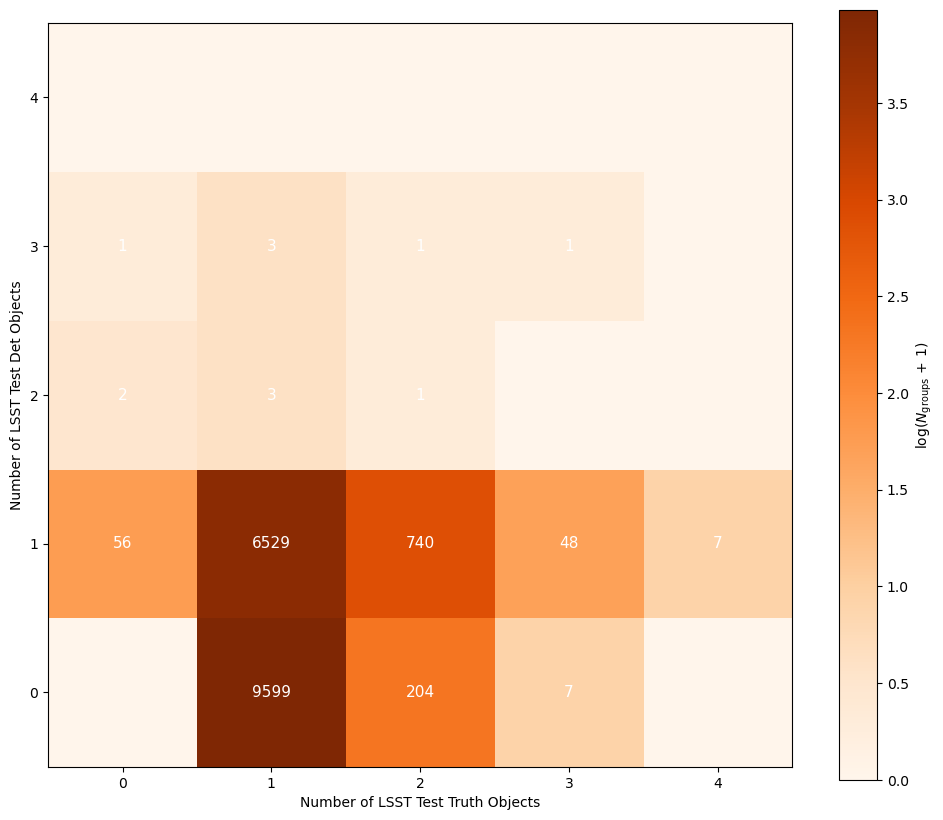

In [66]:
plot_matches(lsst_truth_lsst_det, x_axis_name='lsst_test_truth', xlabel='LSST Test Truth Objects', ylabel='LSST Test Det Objects')

### Roman Test Det vs LSST Test Det

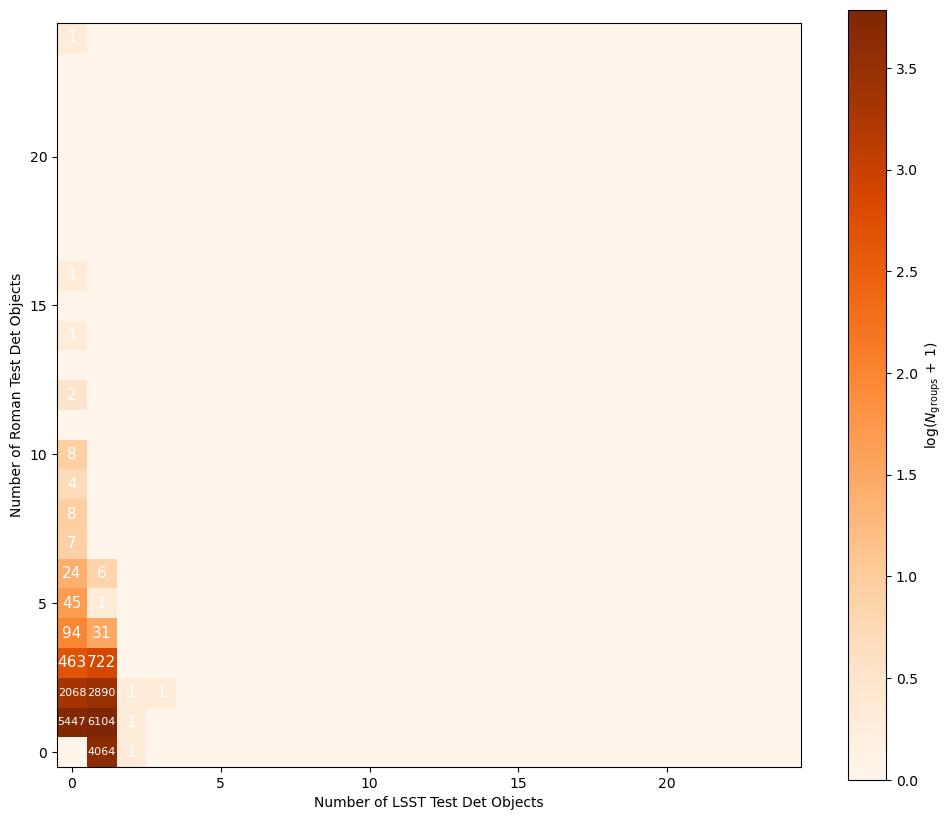

In [31]:
# plot_matches(roman_det_lsst_det1, x_axis_name='lsst_test_det', xlabel='LSST Test Det Objects', ylabel='Roman Test Det Objects')
plot_matches(roman_det_lsst_det05, x_axis_name='lsst_test_det', xlabel='LSST Test Det Objects', ylabel='Roman Test Det Objects')

### DeepDISC Det vs LSST Truth 

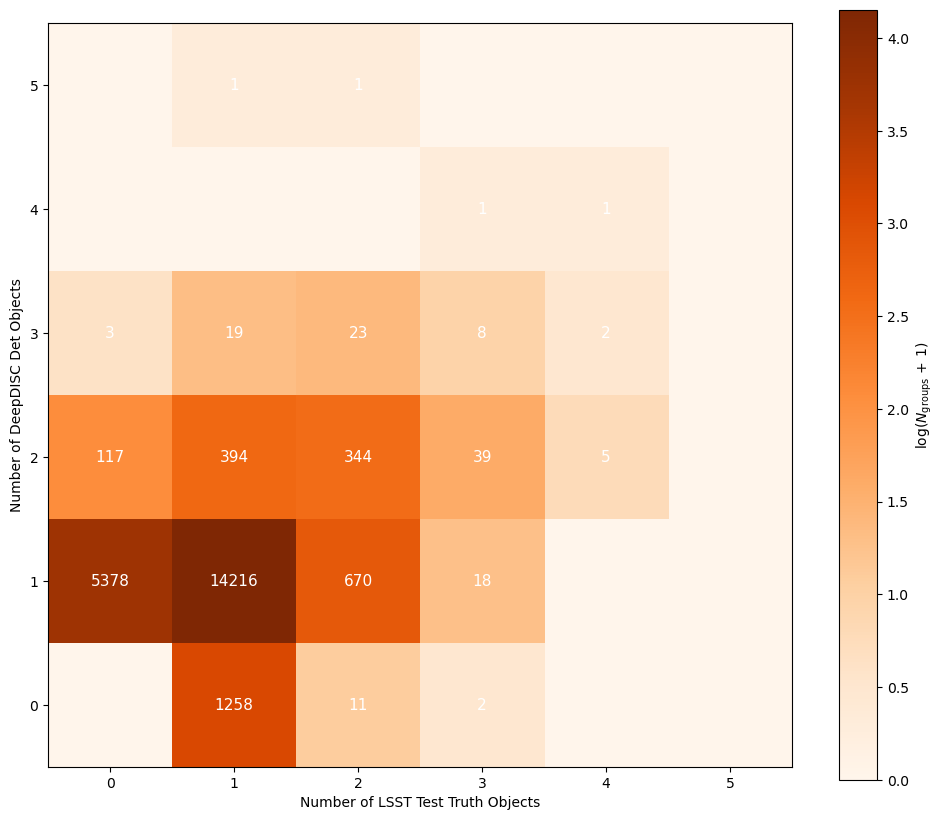

In [71]:
plot_matches(dd_det_lsst_truth1, x_axis_name='lsst_test_truth', xlabel='LSST Test Truth Objects', ylabel='DeepDISC Det Objects')

### DeepDISC Det vs LSST Det

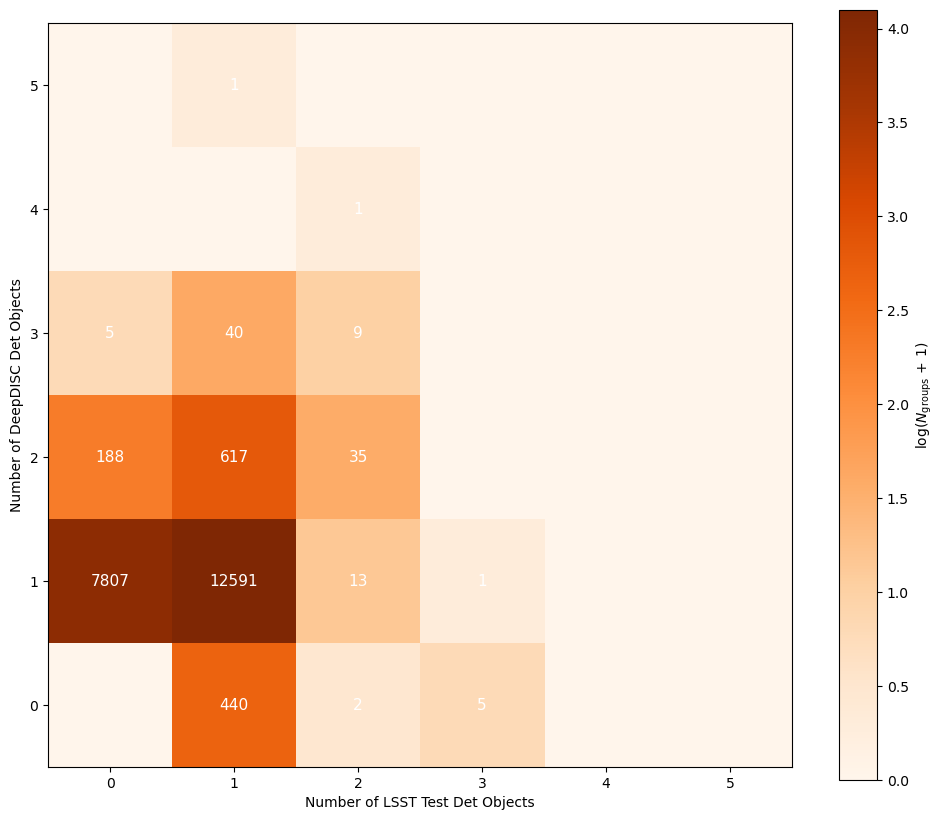

In [32]:
plot_matches(dd_det_lsst_det1, x_axis_name='lsst_test_det', xlabel='LSST Test Det Objects', ylabel='DeepDISC Det Objects')

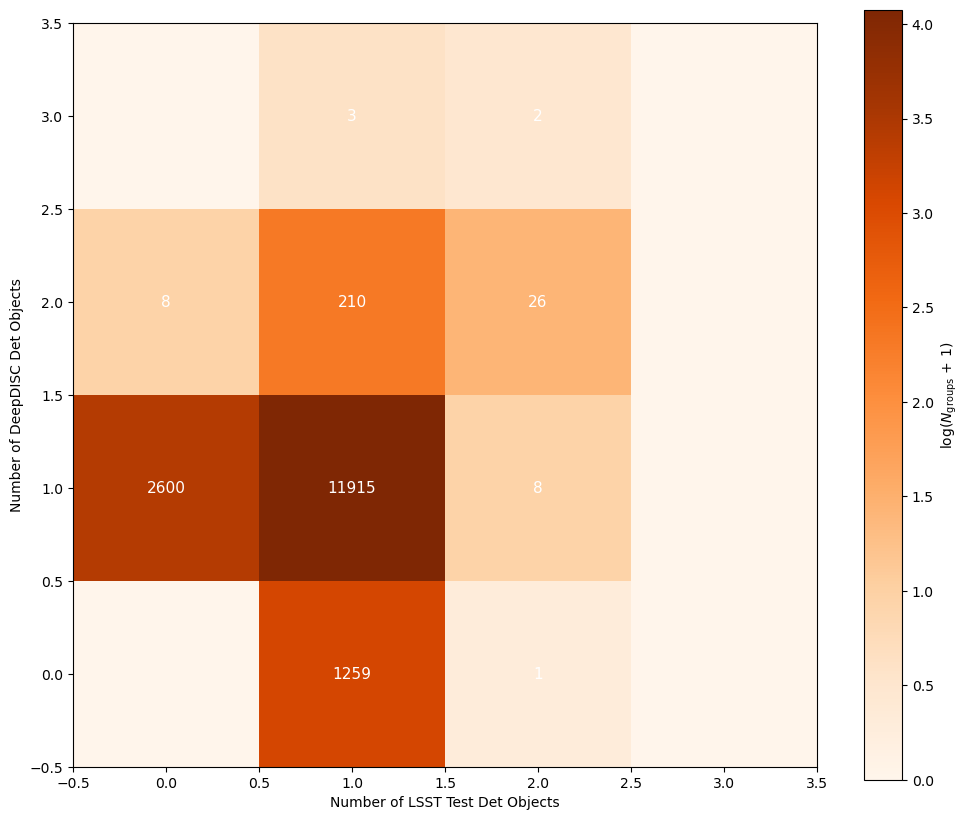

In [85]:
plot_matches(dd_det_lsst_det1, x_axis_name='lsst_test_det', xlabel='LSST Test Det Objects', ylabel='DeepDISC Det Objects')
# mag histograms, size, colors props of 2600, 210 and 1259

# Plotting Unrecognized Blends

In [87]:
def calculate_blend_fraction(results, x_axis_name, mags, mag_bins):
    # first we need to know which rows are from the x-axis cat (catalog A) and which are from y-axis cat (catalog B)
    cat_a_mask = results['catalog_key'] == x_axis_name
    cat_b_mask = ~cat_a_mask
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    
    # let's go with the convention that we have LSST Det/Truth on the x-axis (cat_a)
    # then the unrecognized blends will be where LSST Det/Truth thought it was one object but DeepDISC detected it as 2
    blend_mask = (n_a == 1) & (n_b > 1) # where 
    # group_ids for LSST objects only
    lsst_group_ids = results['group_id'][cat_a_mask]
    # mask for blended LSST objects
    lsst_blend_mask = np.isin(lsst_group_ids, np.where(blend_mask)[0])
    # now we use this mask to select magnitudes of blended objects
    blend_mags = mags[lsst_blend_mask]
    
    blend_objects_per_bin, _ = np.histogram(blend_mags, bins=mag_bins)
    total_objects_per_bin, _ = np.histogram(mags, bins=mag_bins)
    
    blend_fraction = blend_objects_per_bin / total_objects_per_bin
    
    return blend_fraction


def plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, title, xlabel='i'):
    plt.figure(figsize=(10, 6))
    plt.plot(mag_bins[:-1], blend_fraction_1arcsec, '-', label='Matching 1"')
    plt.plot(mag_bins[:-1], blend_fraction_05arcsec, '-g', label='Matching 0.5"')

    plt.xlabel(f'${xlabel}$ magnitude')
    plt.ylabel('Unrecognized blend fraction')
    plt.title(f'Proportion of Unrecognized Blends to Total Matched Objects - {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)

def calculate_blend_fraction_with_errors(results, x_axis_name, mags, mag_bins):
    cat_a_mask = results['catalog_key'] == x_axis_name
    cat_b_mask = ~cat_a_mask
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    
    blend_mask = (n_a == 1) & (n_b > 1)
    lsst_group_ids = results['group_id'][cat_a_mask]
    lsst_blend_mask = np.isin(lsst_group_ids, np.where(blend_mask)[0])
    blend_mags = mags[lsst_blend_mask]
    
    blend_objects_per_bin, _ = np.histogram(blend_mags, bins=mag_bins)
    total_objects_per_bin, _ = np.histogram(mags, bins=mag_bins)
    
    blend_fraction = blend_objects_per_bin / total_objects_per_bin
    
    # binomial errors
    # (sqrt(p(1-p)/n) where p is blend fraction and n is total number of objects in each bin)
    # bins w/ non-zero total objects
    errors = np.zeros_like(blend_fraction)
    mask = total_objects_per_bin > 0
    errors[mask] = np.sqrt(blend_fraction[mask] * (1 - blend_fraction[mask]) / total_objects_per_bin[mask])
    
    return blend_fraction, errors

def plot_unrec_blend_with_errors(blend_fraction_1arcsec, errors_1arcsec, 
                               blend_fraction_05arcsec, errors_05arcsec, 
                               mag_bins, title, xlabel='i'):
    plt.figure(figsize=(10, 6))
    
    bin_centers = (mag_bins[:-1] + mag_bins[1:]) / 2
    
    plt.errorbar(bin_centers, blend_fraction_1arcsec, yerr=errors_1arcsec, 
                fmt='-', label='Matching 1"', capsize=3)
    plt.errorbar(bin_centers, blend_fraction_05arcsec, yerr=errors_05arcsec, 
                fmt='-', label='Matching 0.5"', color='green', capsize=3)

    plt.xlabel(f'${xlabel}$ magnitude')
    plt.ylabel('Unrecognized blend fraction')
    plt.title(f'Proportion of Unrecognized Blends to Total Matched Objects - {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
def calculate_overall_blend_fraction(results, x_axis_name):
    # first we need to know which rows are from the x-axis cat (catalog A) and which are from y-axis cat (catalog B)
    cat_a_mask = results['catalog_key'] == x_axis_name
    cat_b_mask = ~cat_a_mask
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    
    blend_mask = (n_a == 1) & (n_b > 1)
    
    total_matches = np.sum(n_a > 0)  # num of matched LSST objects
    total_blends = np.sum(blend_mask)  # num of unrecognized blends
    
    blend_fraction = total_blends / total_matches
    
    return blend_fraction

## Non-Combined

### LSST DET vs LSST Truth

In [61]:
magnitudes = np.array(truth_mags)
# mag_bins = np.arange(min(magnitudes), max(magnitudes), 2)
mag_bins = np.arange(20, 30, 0.5)
# mag_bins = np.arange(20, 30, 1)
blend_fraction_1arcsec = calculate_blend_fraction(lsst_det_lsst_truth1, x_axis_name='lsst_truth', mags=magnitudes, mag_bins=mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(lsst_det_lsst_truth05, x_axis_name='lsst_truth', mags=magnitudes, mag_bins=mag_bins)

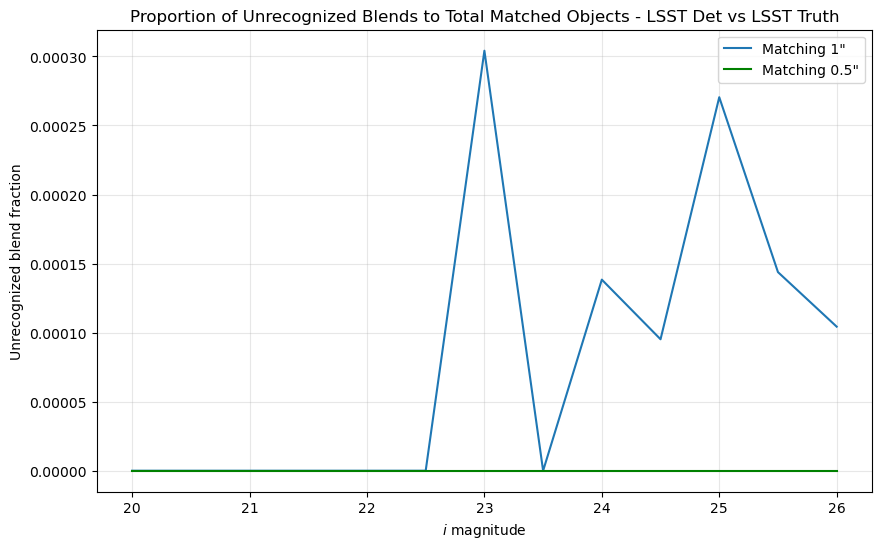

In [62]:
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'LSST Det vs LSST Truth')

### DeepDISC Det vs LSST Truth

In [45]:
magnitudes = np.array(test_truth_mags)
mag_bins = np.arange(min(magnitudes), max(magnitudes), 1)
# mag_bins = np.arange(20, 30, 1)
blend_fraction_1arcsec = calculate_blend_fraction(dd_det_lsst_truth1, x_axis_name='lsst_test_truth', mags=magnitudes, mag_bins=mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(dd_det_lsst_truth05, x_axis_name='lsst_test_truth', mags=magnitudes, mag_bins=mag_bins)

In [ ]:
overall_bf = calculate_overall_blend_fraction(dd_det_lsst_truth1, 'lsst_test_truth')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(dd_det_lsst_truth05, 'lsst_test_truth')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")

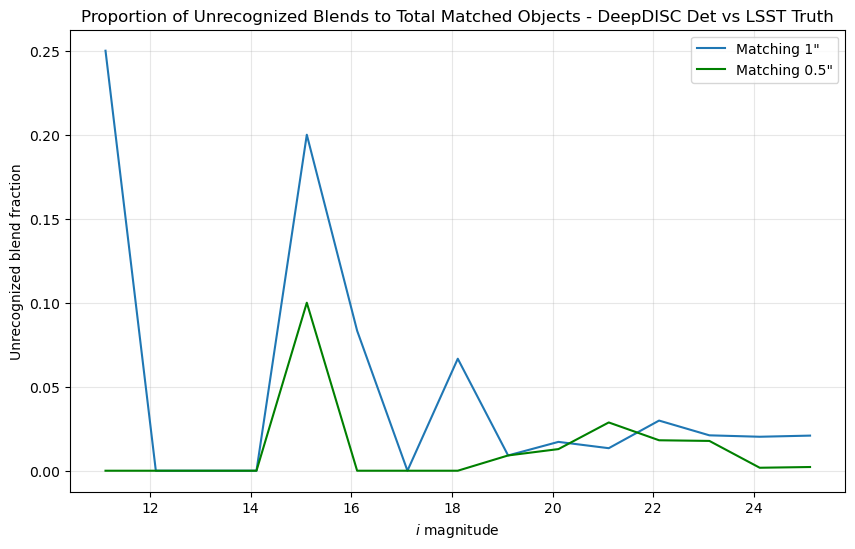

In [46]:
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'DeepDISC Det vs LSST Truth')

### DeepDISC Det vs LSST Det

In [62]:
magnitudes = np.array(test_det_mags)
# mag_bins = np.arange(min(magnitudes), max(magnitudes), 1)
mag_bins = np.arange(18, 25.63, 0.5)
blend_fraction_1arcsec = calculate_blend_fraction(dd_det_lsst_det1, x_axis_name='lsst_test_det', mags=magnitudes, mag_bins=mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(dd_det_lsst_det05, x_axis_name='lsst_test_det', mags=magnitudes, mag_bins=mag_bins)

In [63]:
overall_bf = calculate_overall_blend_fraction(dd_det_lsst_det1, 'lsst_test_det')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(dd_det_lsst_det05, 'lsst_test_det')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")

Unrecognized blend fraction (1 arcsec matching): 0.0379
Unrecognized blend fraction (0.5 arcsec matching): 0.0066


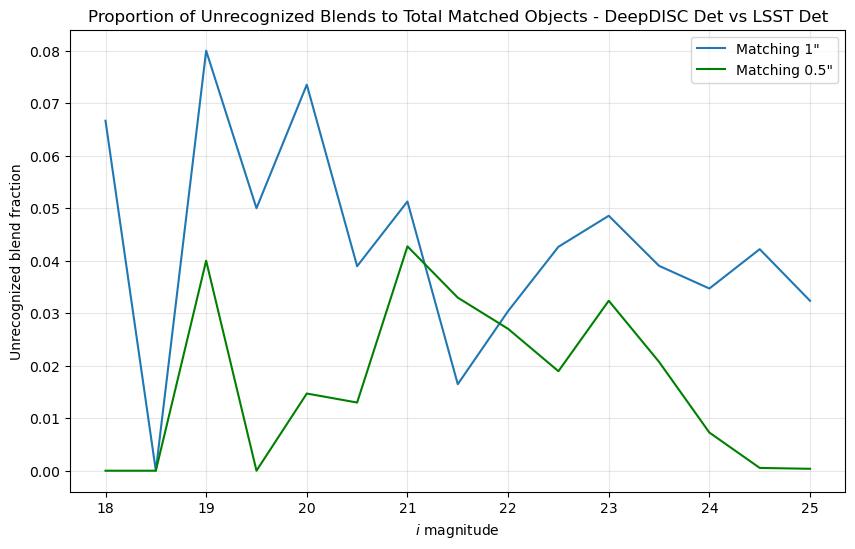

In [64]:
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'DeepDISC Det vs LSST Det') # try with diff mag cuts

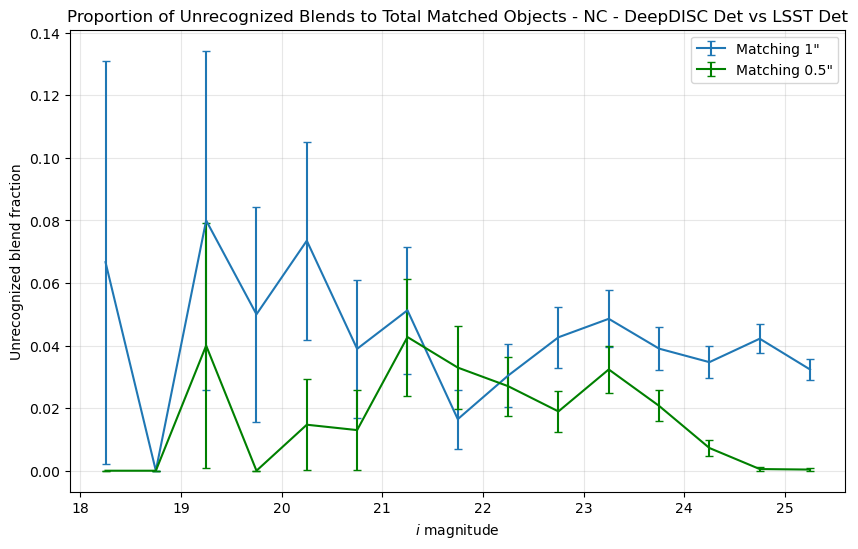

In [66]:
blend_fraction_1arcsec, errors_1arcsec = calculate_blend_fraction_with_errors(
    dd_det_lsst_det1, 'lsst_test_det', mags=magnitudes, mag_bins=mag_bins)

blend_fraction_05arcsec, errors_05arcsec = calculate_blend_fraction_with_errors(
    dd_det_lsst_det05, 'lsst_test_det', mags=magnitudes, mag_bins=mag_bins)

plot_unrec_blend_with_errors(
    blend_fraction_1arcsec, errors_1arcsec,
    blend_fraction_05arcsec, errors_05arcsec,
    mag_bins, 'NC - DeepDISC Det vs LSST Det')

## Combined

In [34]:
magnitudes = np.array(det_mags)
# mag_bins = np.arange(min(magnitudes), max(magnitudes), 1)
mag_bins = np.arange(18, 25.63, 0.5)
# mag_bins = np.arange(20, 30, 1)
blend_fraction_1arcsec = calculate_blend_fraction(roman_det_lsst_det1, x_axis_name='lsst_test_det', mags=magnitudes, mag_bins=mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(roman_det_lsst_det05, x_axis_name='lsst_test_det', mags=magnitudes, mag_bins=mag_bins)

In [35]:
overall_bf = calculate_overall_blend_fraction(roman_det_lsst_det1, 'lsst_test_det')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(roman_det_lsst_det05, 'lsst_test_det')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")

Unrecognized blend fraction (1 arcsec matching): 0.2814
Unrecognized blend fraction (0.5 arcsec matching): 0.2641


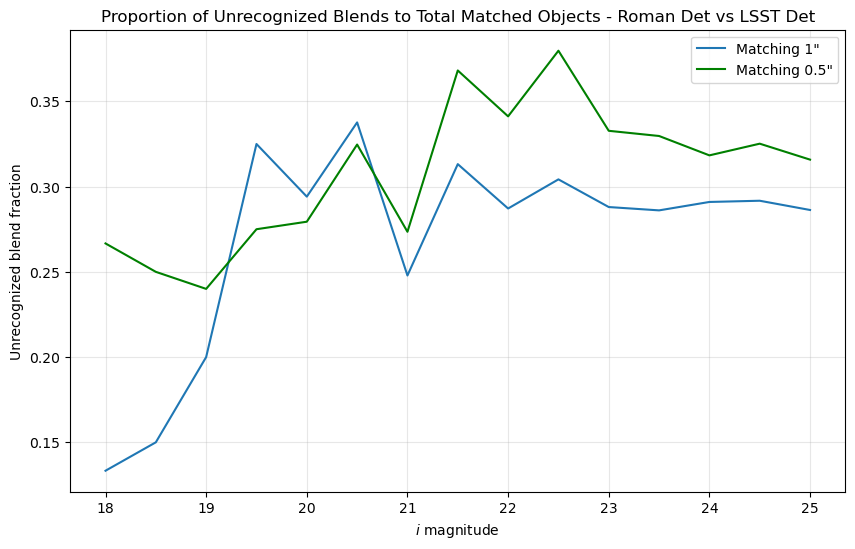

In [36]:
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'Roman Det vs LSST Det')

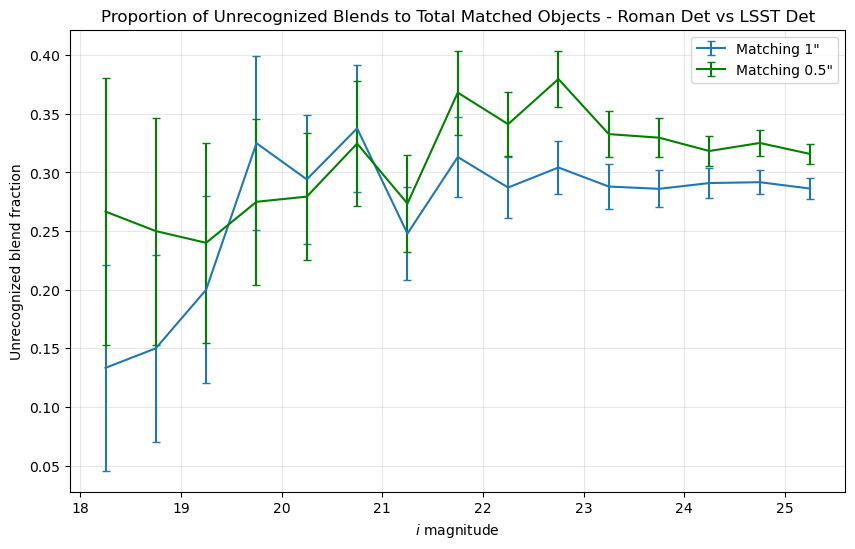

In [37]:
blend_fraction_1arcsec, errors_1arcsec = calculate_blend_fraction_with_errors(
    roman_det_lsst_det1, 'lsst_test_det', mags=magnitudes, mag_bins=mag_bins)

blend_fraction_05arcsec, errors_05arcsec = calculate_blend_fraction_with_errors(
    roman_det_lsst_det05, 'lsst_test_det', mags=magnitudes, mag_bins=mag_bins)

plot_unrec_blend_with_errors(
    blend_fraction_1arcsec, errors_1arcsec,
    blend_fraction_05arcsec, errors_05arcsec,
    mag_bins, 'Roman Det vs LSST Det')

### DeepDISC Det vs LSST Truth

In [58]:
magnitudes = np.array(test_truth_mags)
mag_bins = np.arange(min(magnitudes), max(magnitudes), 1)
# mag_bins = np.arange(20, 30, 1)
blend_fraction_1arcsec = calculate_blend_fraction(dd_det_lsst_truth1, x_axis_name='lsst_test_truth', mags=magnitudes, mag_bins=mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(dd_det_lsst_truth05, x_axis_name='lsst_test_truth', mags=magnitudes, mag_bins=mag_bins)

In [64]:
overall_bf = calculate_overall_blend_fraction(dd_det_lsst_truth1, 'lsst_test_truth')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(dd_det_lsst_truth05, 'lsst_test_truth')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")

Unrecognized blend fraction (1 arcsec matching): 0.0243
Unrecognized blend fraction (0.5 arcsec matching): 0.0069


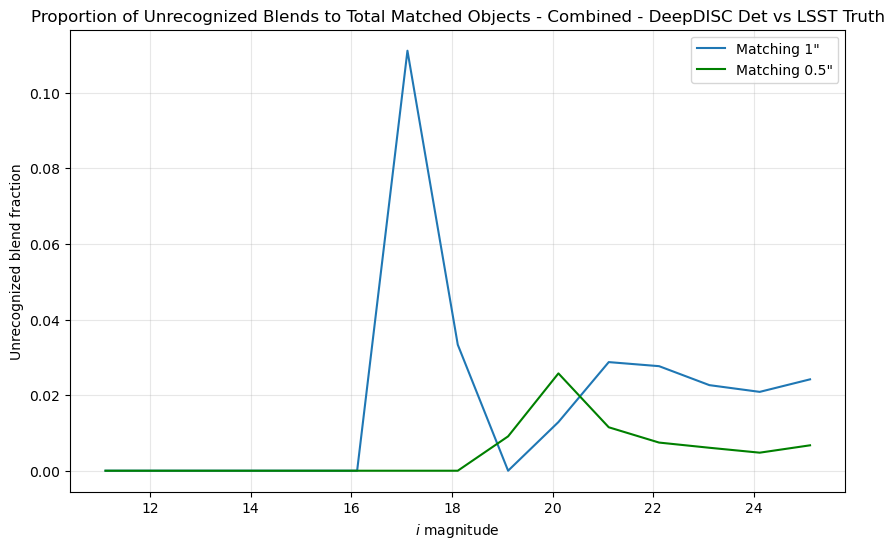

In [59]:
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'Combined - DeepDISC Det vs LSST Truth')

### DeepDISC Det vs LSST Det

In [88]:
# only select objs that have a corresponding match in LSST truth catalog getting rid of spurious detections
# forced photometry using DeepDISC dets --> photometric catalog that we can use
# ensure 80% completeness for LSST Det/LSST Truth
# bootstrap entire sample rather than each bin
# are there less objects being detected by DeepDISC than there exists in Roman/LSST detection catalog? as well as example imgs
# 1-1 match deepdisc with LSST truth and get obj's mags and get distribution based on that and compare it to the patch distribution (to see what kind of objs deepdisc is detecting)
# do 1-1 matching of detections to truth and pass in FOF basically filtering out the ones that don't have a 1-1 match
# sanity check: lsst truth and roman truth
magnitudes = np.array(test_det_mags)
# mag_bins = np.arange(min(magnitudes), max(magnitudes), 0.5)
mag_bins = np.arange(18, 25.63, 0.5)
blend_fraction_1arcsec = calculate_blend_fraction(dd_det_lsst_det1, x_axis_name='lsst_test_det', mags=magnitudes, mag_bins=mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(dd_det_lsst_det05, x_axis_name='lsst_test_det', mags=magnitudes, mag_bins=mag_bins)

In [42]:
overall_bf = calculate_overall_blend_fraction(dd_det_lsst_det1, 'lsst_test_det')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(dd_det_lsst_det05, 'lsst_test_det')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")

Unrecognized blend fraction (1 arcsec matching): 0.0478
Unrecognized blend fraction (0.5 arcsec matching): 0.0077


In [89]:
overall_bf = calculate_overall_blend_fraction(dd_det_lsst_det1, 'lsst_test_det')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(dd_det_lsst_det05, 'lsst_test_det')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")

Unrecognized blend fraction (1 arcsec matching): 0.0159
Unrecognized blend fraction (0.5 arcsec matching): 0.0007


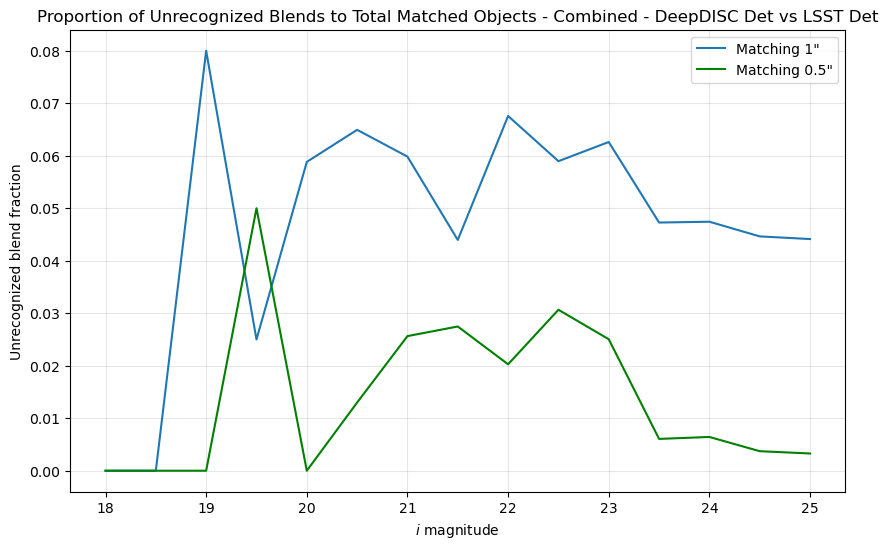

In [44]:
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'Combined - DeepDISC Det vs LSST Det')

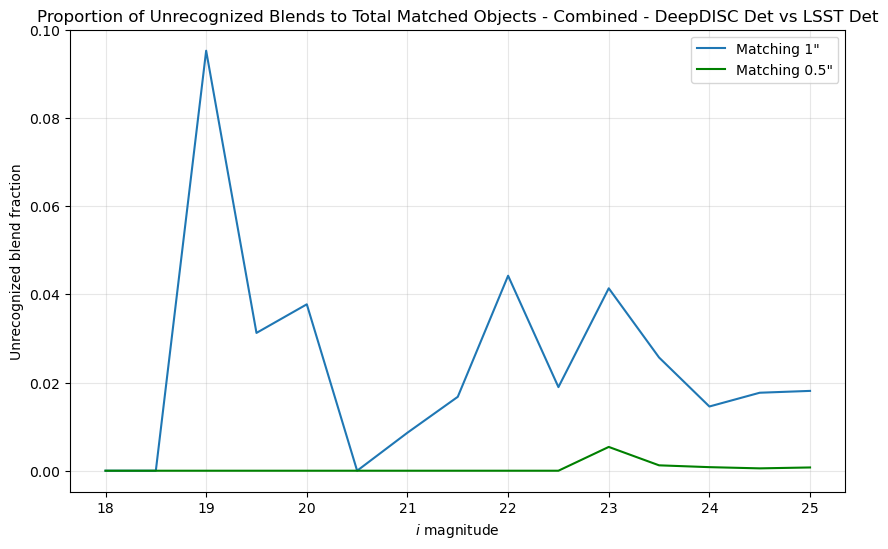

In [90]:
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'Combined - DeepDISC Det vs LSST Det')

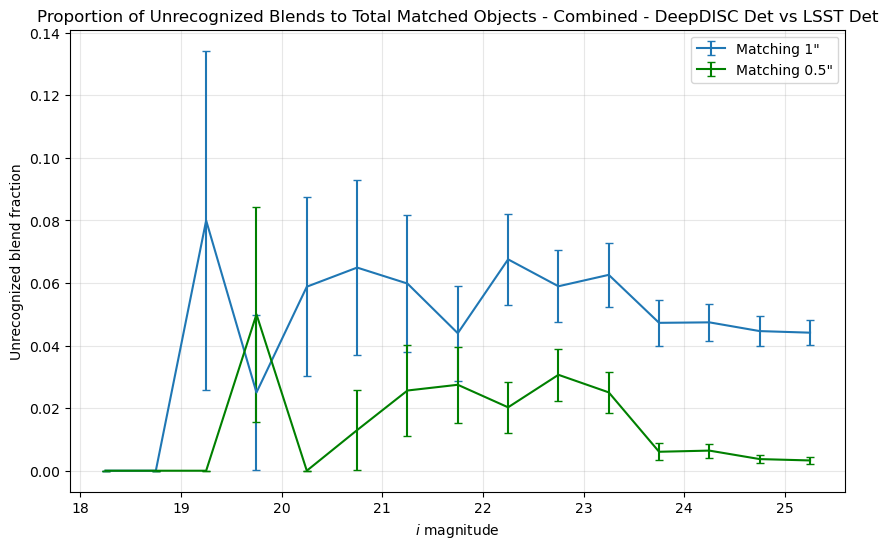

In [45]:
blend_fraction_1arcsec, errors_1arcsec = calculate_blend_fraction_with_errors(
    dd_det_lsst_det1, 'lsst_test_det', mags=magnitudes, mag_bins=mag_bins)

blend_fraction_05arcsec, errors_05arcsec = calculate_blend_fraction_with_errors(
    dd_det_lsst_det05, 'lsst_test_det', mags=magnitudes, mag_bins=mag_bins)

plot_unrec_blend_with_errors(
    blend_fraction_1arcsec, errors_1arcsec,
    blend_fraction_05arcsec, errors_05arcsec,
    mag_bins, 'Combined - DeepDISC Det vs LSST Det')

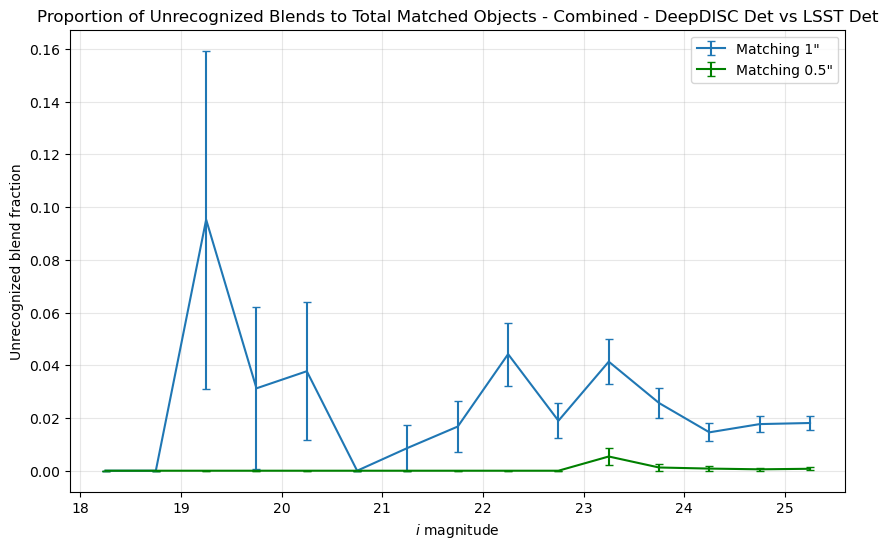

In [91]:
# 1-1 matching
blend_fraction_1arcsec, errors_1arcsec = calculate_blend_fraction_with_errors(
    dd_det_lsst_det1, 'lsst_test_det', mags=magnitudes, mag_bins=mag_bins)

blend_fraction_05arcsec, errors_05arcsec = calculate_blend_fraction_with_errors(
    dd_det_lsst_det05, 'lsst_test_det', mags=magnitudes, mag_bins=mag_bins)

plot_unrec_blend_with_errors(
    blend_fraction_1arcsec, errors_1arcsec,
    blend_fraction_05arcsec, errors_05arcsec,
    mag_bins, 'Combined - DeepDISC Det vs LSST Det')

In [68]:
import pandas as pd
import seaborn as sns
def get_metrics(test_data, imreader, predictor, key_mapper, mag_type='mag_i', by_mag=False, flow=0, fhigh=30):
    TP=FN=FP=0
    TP_classes = np.array([0,0])
    pred_tots = np.array([0,0]) # holds number of detected objs for each class
    gt_tots = np.array([0,0]) # holds number of true objs for each class
    confusion_matrix = np.zeros((2, 2), dtype=int)
    
    all_matched_gts = []
    all_matched_dts = []
    cls_ids = [0,1]
#     total_stars = total_galaxies = 0
# use 1" to catalog match and grab the bboxes and then change to RA and DEC and match with the ra's and decs
    for d in test_data:
        outputs = get_predictions(d, imreader, key_mapper, predictor)
        IOUthresh = 0.5
        gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
#         for ann in d["annotations"]:
#             if ann["category_id"] == 1:
#                 total_stars += 1
#             else:
#                 total_galaxies += 1
        # Convert to the mode model expects
        # Make sure the input bboxes are in XYWH mode so they can be converted here
        if gt_boxes.shape[0] != 0: # as some images don't have any annotation or no preds from the model
            gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            gt_boxes = structures.Boxes(torch.Tensor(gt_boxes))
            pred_boxes = outputs["instances"].pred_boxes.to("cpu")
            IOUs = structures.pairwise_iou(pred_boxes, gt_boxes).numpy()
            # matched_gts holds the indices of the ground truth annotations that correspond to the matched detections
            # matched_dts holds the indices of the detections that corresponds to the ground truth annotations
            matched_gts = []
            matched_dts =[]
            for i, dt in enumerate(IOUs):
                # might allow a gt box to match with multiple preds if those preds have highest IoU with same gt box
                # leads to double-counting unless handled to ensure that once a ground truth box is matched, not considered for further matches
                IOU = dt[dt.argmax()]
                mag = d['annotations'][dt.argmax()][mag_type]
                if by_mag:
#                 #considered a true detection if above the threshold
                    if IOU>=IOUthresh and mag>=flow and mag<fhigh:
                        matched_gts.append(dt.argmax())
                        matched_dts.append(i)
                else:
                    if IOU>=IOUthresh:
                        matched_gts.append(dt.argmax())
                        matched_dts.append(i)                         
#                 matched_gts.append(dt.argmax())
#                 matched_dts.append(i) 
            all_matched_gts.append(set(matched_gts))
            all_matched_dts.append(set(matched_dts))
                
            TP += len(matched_gts)
            # num of gt boxes - matched num of gt boxes that were matched w/ pred boxes
            # account for gt boxes that didn't match any pred boxes
            FN += (IOUs.shape[1] - len(set(matched_gts)))
            # num of pred boxes - matched num of dt that were matched w/ gt boxes
            # account for the preds that didn't match any ground truth boxes
            FP += (IOUs.shape[0] - len(set(matched_dts))) 

            for gti, dti in zip(matched_gts, matched_dts):
                class_gt = d['annotations'][gti]['category_id']
                class_dt = outputs['instances'][dti].pred_classes.cpu().detach().numpy()
                confusion_matrix[class_gt, class_dt] += 1
                for ci, c in enumerate(cls_ids):
                    if class_gt == class_dt == c:
                        TP_classes[ci] += 1
                    if class_dt == c:
                        pred_tots[ci] += 1
                    if class_gt == c:
                        gt_tots[ci] += 1

#     total_true_instances = sum([len(d['annotations']) for d in test_data])
#     print(f"Total true instances (calculated directly): {total_true_instances}")
#     print(f"Total stars (calculated directly): {total_stars}")
#     print(f"Total galaxies (calculated directly): {total_galaxies}")

#     print(f"Total true instances (from gt_tots): {sum(gt_tots)}")
#     print(f"Total stars (from gt_tots): {gt_tots[1]}")
#     print(f"Total galaxies (from gt_tots): {gt_tots[0]}")
#     assert total_true_instances == sum(gt_tots), "Mismatch in true instance counts"
#     assert total_stars == gt_tots[1], "Mismatch in star counts"
#     assert total_galaxies == gt_tots[0], "Mismatch in galaxy counts"    

    # how well the model does in detecting positive examples that exist in the truth catalog, etc
    det_precision = TP/(TP + FP) if TP + FP > 0 else 0
    det_recall = TP/(TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (det_precision * det_recall) / (det_precision + det_recall) if det_precision + det_recall > 0 else 0
    
    confusion_df = pd.DataFrame(confusion_matrix,
                                index=['True Galaxy', 'True Star'],
                                columns=['Pred Galaxy', 'Pred Star'])
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_df, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    output_path = os.path.join(run_dir, f"confusion_matrix.png")
#     plt.savefig(output_path)
    print(f"Plots saved to {output_path}")
    
    # calc of the below are correct
    FP_classes = pred_tots - TP_classes
    FN_classes = gt_tots - TP_classes
    # metrics[0] is assuming galaxy as pos example and star as neg example whereas metrics[1] is vice versa
    precision_classes = TP_classes / (TP_classes + FP_classes)
    recall_classes = TP_classes / (TP_classes + FN_classes)
    f1_classes = 2 * (precision_classes * recall_classes) / (precision_classes + recall_classes)
    
    # macro averaging to obtain overall performance (unweighted mean to treat all classes equally)
    avg_precision = precision_classes.mean()
    avg_recall = recall_classes.mean()
    avg_f1_score = f1_classes.mean()
    
    metrics = pd.DataFrame({ "Galaxy": [precision_classes[0], recall_classes[0], FP_classes[0], FN_classes[0], f1_classes[0], gt_tots[0]],
                       "Star": [precision_classes[1], recall_classes[1], FP_classes[1], FN_classes[1], f1_classes[1], gt_tots[1]],
                       "Overall": [avg_precision, avg_recall, sum(FP_classes), sum(FN_classes), avg_f1_score, sum(gt_tots)],
                        "Detection": [det_precision, det_recall, None, None, f1_score, None]
                      }, index=['Precision','Recall', 'False Positives', 'False Negatives', 'F1-Score', 'True Objs'])
    
    return metrics, all_matched_gts, all_matched_dts

In [240]:
metrics_df, all_matched_gts, all_matched_dts = get_metrics(test_data, imreader, predictor, img_key_mapper, by_mag=True, mag_type='mag_r')
metrics_df

NameError: name 'get_metrics' is not defined

# OUTDATED - Getting Subset of Test LSST Truth Cat using Test Truth Cat

In [ ]:
len(truth_cat_df)

19404

In [ ]:
lsst_truth = pd.read_json('/home/shared/hsc/roman_lsst/lsst_catalogs/overlap_lsst_truth_cat.json')
len(lsst_truth)

89879

In [ ]:
# we already have these mag cuts in the detection file
# but not in the truth file
lsst_truth_cut = lsst_truth[(lsst_truth['mag_i'] < 26.4) & (lsst_truth['mag_r'] < 26.9)]
len(lsst_truth), len(lsst_truth_cut)

(89879, 88049)

In [ ]:
lsst_truth_cut.columns

Index(['flux_i', 'cosmodc2_hp', 'flux_r', 'patch', 'truth_type', 'flux_z',
       'cosmodc2_id', 'tract', 'mag_y', 'mag_r', 'flux_u', 'mag_z',
       'dec_truth_merged', 'id_string', 'ra_truth_merged', 'flux_y',
       'redshift_truth_merged', 'flux_g', 'mag_i', 'id', 'mag_g', 'mag_u',
       'ellipticity_1_disk_true', 'shear_1', 'ellipticity_1_true',
       'LSST_filters/diskLuminositiesStellar:LSST_y:observed', 'A_v',
       'mag_true_y', 'size_bulge_true', 'mag_true_i', 'bulge_to_total_ratio_i',
       'size_minor_true', 'size_minor_disk_true', 'size_true',
       'ellipticity_2_bulge_true', 'ellipticity_1_bulge_true', 'mag_true_g',
       'mag_true_r', 'ellipticity_2_disk_true',
       'LSST_filters/diskLuminositiesStellar:LSST_u:observed', 'convergence',
       'R_v', 'mag_true_z', 'size_minor_bulge_true', 'size_disk_true',
       'dec_cosmodc2', 'ellipticity_2_true', 'position_angle_true_dc2',
       'ra_cosmodc2', 'mag_true_u', 'redshift_cosmodc2',
       'LSST_filters/spheroidL

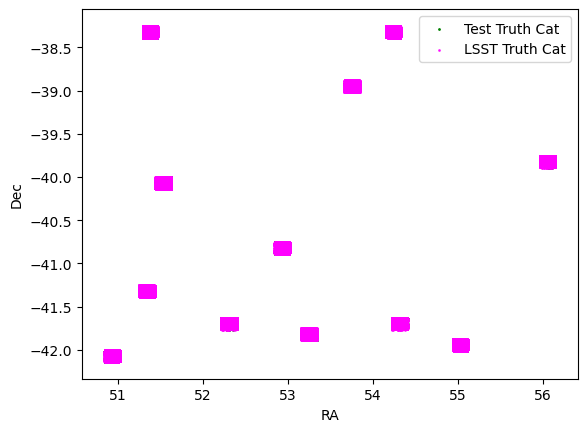

In [ ]:
plt.scatter(truth_cat_df['ra'], truth_cat_df['dec'], s=1, c=['green'], label='Test Truth Cat')
plt.scatter(lsst_truth_cut['ra_truth_merged'], lsst_truth_cut['dec_truth_merged'], s=1, c=['magenta'], label='LSST Truth Cat', alpha=0.8)
plt.xlabel('RA')
plt.ylabel('Dec')
# plt.xlim(51.25,51.50)
# plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

So, we can see that we defintely need to cut down our LSST Truth Catalog further. But, our test truth cat should have a 1-1 exact match with the objects in the LSST Truth Cat.

In [ ]:
ras = truth_cat_df.ra.values
decs = truth_cat_df.dec.values
test_truth_coord = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)

# using lsst truth with mag cuts
ras_2 = lsst_truth_cut.ra_truth_merged.values
decs_2 = lsst_truth_cut.dec_truth_merged.values
lsst_truth_cut_coords = SkyCoord(ra=ras_2*u.degree, dec=decs_2*u.degree)

# # using full lsst truth with no mag cuts
# ras_2 = lsst_truth.ra_truth_merged.values
# decs_2 = lsst_truth.dec_truth_merged.values
# lsst_truth_cut_coords = SkyCoord(ra=ras_2*u.degree, dec=decs_2*u.degree)

idx, d2d, d3d = test_truth_coord.match_to_catalog_sky(lsst_truth_cut_coords)
max_sep = 0.5 * u.arcsec
sep_constraint = (d2d.to(u.arcsec)) < max_sep
# using lsst truth with mag cuts
lsst_test_truth = lsst_truth_cut.iloc[idx[sep_constraint]]

# # using full lsst truth with no mag cuts
# lsst_test_truth = lsst_truth.iloc[idx[sep_constraint]]

In [ ]:
len(lsst_test_truth), len(np.unique(lsst_test_truth['ra_truth_merged']))

(17083, 16967)

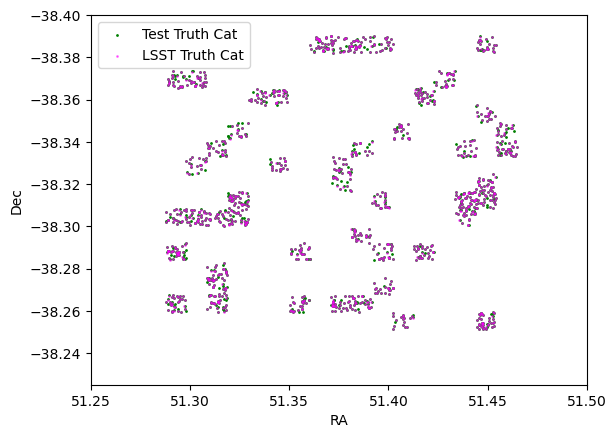

In [ ]:
plt.scatter(truth_cat_df['ra'], truth_cat_df['dec'], s=1, c=['green'], label='Test Truth Cat')
plt.scatter(lsst_test_truth['ra_truth_merged'], lsst_test_truth['dec_truth_merged'], s=1, c=['magenta'], label='LSST Truth Cat', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

So, it seems like we're not having the 1-1 ratio we are expecting to (even with the full lsst_truth that doesn't have any mag cuts `lsst_truth`). This might be because the ground truth boxes that we have generated with galsim annotations are not fully accurate (which doesn't make sense since we're using the truth catalog in the first place to create the bounding boxes).

In [ ]:
lsst_test_truth.to_json('/home/yse2/lsst_data/annotations/lsst_test_truth_cat.json', orient='records')